# ODIR-5K RET-CLIP Unified Pipeline

This notebook implements a complete end-to-end pipeline for training **RET-CLIP** on the **ODIR-5K dataset** with English clinical text.

---

## Research Contribution

**"English BERT Embeddings for Binocular Retinal Image-Text Alignment"**

- ✅ First validation of RET-CLIP architecture on English clinical text
- ✅ Cross-lingual transfer validation (original: Chinese → our work: English)
- ✅ Real binocular fundus images from ODIR-5K (not duplicated monocular)
- ✅ Comparison of medical domain-specific vs general BERT models

---

## Dataset: ODIR-5K (Ocular Disease Intelligent Recognition)

- **5,000 patients** with genuine paired left/right eye fundus images
- **10,000 images** total (2 per patient)
- **Metadata**: Patient Age, Sex, Diagnostic Keywords (English)
- **8 Disease Categories**: Normal, Diabetes, Glaucoma, Cataract, AMD, Hypertension, Myopia, Other

---

## RET-CLIP Architecture

**Binocular Vision-Language Foundation Model**

```
Left Eye Image  ──→  Vision Encoder  ──→  Left Projection  ─┐
                                                             ├─→ Tripartite Loss
Right Eye Image ──→  Vision Encoder  ──→  Right Projection ─┤
                                                             │
Clinical Text   ──→  Text Encoder    ──→  Text Embedding   ─┘
```

**Three-Level Contrastive Learning**:
1. Left eye ↔ Left-specific clinical description
2. Right eye ↔ Right-specific clinical description
3. Patient-level ↔ Holistic diagnostic impression (both eyes)

---

## Pipeline Overview

```
1. Setup & Configuration        → Install packages, authenticate APIs
2. Load ODIR-5K Dataset         → CSV metadata + paired fundus images
3. Generate Clinical Prompts    → DSPy + OpenRouter (3 prompts/patient)
4. Preprocess for RET-CLIP      → TSV + JSONL with eye_side annotations
5. Build LMDB Database          → Efficient PyTorch DataLoader format
6. Train RET-CLIP               → 10 epochs contrastive learning
7. Zero-Shot Evaluation         → Vision-language alignment test
8. Linear Probing Evaluation    → Feature quality assessment
9. Final Report                 → Metrics, comparison, artifacts
```

---

## ⏱️ Estimated Runtime

| Mode | Patients | Prompts Time | Training Time | Total |
|------|----------|--------------|---------------|-------|
| TEST | 100 | ~30 min | ~30 min (2 epochs) | **~2-3 hours** |
| FULL | 5,000 | ~4-5 hours | ~12-15 hours (10 epochs) | **~18-24 hours** |

---

## Prerequisites

1. **Google Colab** with A100 GPU (or T4 for testing)
2. **API Keys**:
   - HuggingFace Token: https://huggingface.co/settings/tokens
   - OpenRouter API Key: https://openrouter.ai/keys
3. **ODIR-5K Dataset**: Will be downloaded automatically

---

**Let's begin!**

# SECTION 1: Setup & Configuration

## Cell 1.1: Check GPU

In [ ]:
# Check GPU availability
!nvidia-smi

Sun Nov 23 13:17:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   33C    P0             53W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Cell 1.2: Mount Google Drive

In [ ]:
# Mount Google Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted successfully")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully


## Cell 1.3: Install Dependencies

In [ ]:
# Install all required packages
print("📦 Installing dependencies...\n")

# DSPy packages (for prompt generation)
!pip install -q dspy-ai datasets huggingface-hub pandas pillow tqdm ipywidgets matplotlib

# RET-CLIP packages (for training)
!pip install -q ftfy regex
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q transformers
!pip install -q lmdb
!pip install -q scikit-learn seaborn

# OpenCV for image processing
!pip install -q opencv-python-headless

# Kaggle dataset download (automatic!)
!pip install -q kagglehub openpyxl

print("\n✅ All dependencies installed")

📦 Installing dependencies...

  Preparing metadata (setup.py) ... done

✅ All dependencies installed


## Cell 1.4: Clone RET-CLIP Repository (with English BERT fixes)

In [ ]:
import os
import shutil
import sys

# Clone repository with fixed RET-CLIP
REPO_URL = "https://github.com/FahadAlothman-fsd/retclip-english.git"

if not os.path.exists('/content/retclip_repo'):
    print(f"Cloning repository from {REPO_URL}...")
    !git clone {REPO_URL} /content/retclip_repo
    print("✅ Repository cloned")
else:
    print("✅ Repository already exists")

# Copy retclip to /content/retclip
if not os.path.exists('/content/retclip'):
    print("\nCopying fixed RET-CLIP...")
    shutil.copytree('/content/retclip_repo/retclip', '/content/retclip')
    print("✅ Copied to /content/retclip")
else:
    print("✅ /content/retclip already exists")

# Add to Python path
sys.path.insert(0, '/content/retclip')
os.environ['PYTHONPATH'] = '/content/retclip'

print("\n✅ RET-CLIP repository ready")
print("\n" + "="*80)
print("VERIFY: Using fixed RET-CLIP with:")
print("="*80)
print("  1. ✓ English BERT configs (PubMedBERT, BERT-base, BioBERT)")
print("  2. ✓ URL-safe base64 encoding/decoding")
print("  3. ✓ 3-column TSV format support (patient_id, left_img, right_img)")
print("  4. ✓ DDP checkpoint loading with 'module.' prefix stripping")
print(f"\nLocation: /content/retclip")
print(f"Source: {REPO_URL}")

✅ Repository already exists
✅ /content/retclip already exists

✅ RET-CLIP repository ready

VERIFY: Using fixed RET-CLIP with:
  1. ✓ English BERT configs (PubMedBERT, BERT-base, BioBERT)
  2. ✓ URL-safe base64 encoding/decoding
  3. ✓ 3-column TSV format support (patient_id, left_img, right_img)
  4. ✓ DDP checkpoint loading with 'module.' prefix stripping

Location: /content/retclip
Source: https://github.com/FahadAlothman-fsd/retclip-english.git


## Cell 1.5: Configuration Parameters

In [ ]:
# Configuration Parameters
import os

# TEST MODE: Set to True for quick testing with subset of data
TEST_MODE = False  # Set to False for full dataset training
NUM_TEST_PATIENTS = 100 if TEST_MODE else None

# TRAINING HYPERPARAMETERS
VISION_MODEL = "ViT-B-16"
IMAGE_SIZE = 224
BATCH_SIZE = 32 if TEST_MODE else 128
NUM_EPOCHS = 2 if TEST_MODE else 20
LEARNING_RATE = 5e-5 if TEST_MODE else 0.00003
WARMUP_STEPS = 500 if TEST_MODE else 50
# BATCH_SIZE = 128
# LEARNING_RATE = 0.00003

# TEXT ENCODER CONFIGURATION
# Default text encoder (used when comparison is disabled)
TEXT_MODEL = "microsoft-BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"

# TEXT ENCODER COMPARISON
RUN_TEXT_ENCODER_COMPARISON = True  # Set to False to train only PubMedBERT (faster)

# PROMPT GENERATION MODEL
PRIMARY_MODEL = "openrouter/google/gemini-2.5-flash-lite"  # Fast, high-quality model for prompt generation

# PROMPT GENERATION SETTINGS
CHECKPOINT_INTERVAL = 10  # Save checkpoint every N patients
DELAY_BETWEEN_CALLS = 0.5  # Delay between API calls (seconds) to avoid rate limiting

print(f"Configuration:")
print(f"  Mode: {'TEST (100 patients, 2 epochs)' if TEST_MODE else 'FULL (5000 patients, 10 epochs)'}")
print(f"  Vision Model: {VISION_MODEL}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Prompt Model: {PRIMARY_MODEL}")
print(f"  Checkpoint Interval: {CHECKPOINT_INTERVAL} patients")
print(f"  API Delay: {DELAY_BETWEEN_CALLS}s")
print(f"\nText Encoder Comparison: {'✅ ENABLED' if RUN_TEXT_ENCODER_COMPARISON else '❌ DISABLED (PubMedBERT only)'}")

if RUN_TEXT_ENCODER_COMPARISON:
    print("   Will train and compare 3 text encoders:")
    print("   - PubMedBERT (medical domain)")
    print("   - BERT-base (general English)")
    print("   - BioBERT (biomedical domain)")

# Define text encoders for comparison
# Note: model_id is for RET-CLIP config files (uses dashes), hf_model_id is for HuggingFace tokenizer (uses slashes)
TEXT_ENCODERS = [
    {
        "name": "PubMedBERT",
        "model_id": "microsoft-BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
        "hf_model_id": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
        "description": "Medical domain-specific BERT trained on PubMed abstracts"
    },
    {
        "name": "BERT-base",
        "model_id": "bert-base-uncased",
        "hf_model_id": "bert-base-uncased",
        "description": "General English BERT (baseline)"
    },
    {
        "name": "BioBERT",
        "model_id": "dmis-lab-biobert-base-cased-v1.1",
        "hf_model_id": "dmis-lab/biobert-base-cased-v1.1",
        "description": "Biomedical domain BERT trained on PubMed + PMC"
    }
]

# GOOGLE DRIVE PATHS (will be set after mounting)
DRIVE_BASE = "/content/drive/MyDrive/RET-CLIP-ODIR"
DRIVE_DATA = f"{DRIVE_BASE}/data"
DRIVE_PROMPTS = f"{DRIVE_BASE}/prompts"
DRIVE_LMDB = f"{DRIVE_BASE}/lmdb"
DRIVE_CHECKPOINTS = f"{DRIVE_BASE}/checkpoints"
DRIVE_RESULTS = f"{DRIVE_BASE}/results"

print(f"\nGoogle Drive paths configured:")
print(f"  Base: {DRIVE_BASE}")
print(f"  Data: {DRIVE_DATA}")
print(f"  Prompts: {DRIVE_PROMPTS}")
print(f"  LMDB: {DRIVE_LMDB}")
print(f"  Checkpoints: {DRIVE_CHECKPOINTS}")
print(f"  Results: {DRIVE_RESULTS}")

Configuration:
  Mode: FULL (5000 patients, 10 epochs)
  Vision Model: ViT-B-16
  Batch Size: 128
  Epochs: 20
  Learning Rate: 3e-05
  Image Size: 224x224
  Prompt Model: openrouter/google/gemini-2.5-flash-lite
  Checkpoint Interval: 10 patients
  API Delay: 0.5s

Text Encoder Comparison: ✅ ENABLED
   Will train and compare 3 text encoders:
   - PubMedBERT (medical domain)
   - BERT-base (general English)
   - BioBERT (biomedical domain)

Google Drive paths configured:
  Base: /content/drive/MyDrive/RET-CLIP-ODIR
  Data: /content/drive/MyDrive/RET-CLIP-ODIR/data
  Prompts: /content/drive/MyDrive/RET-CLIP-ODIR/prompts
  LMDB: /content/drive/MyDrive/RET-CLIP-ODIR/lmdb
  Checkpoints: /content/drive/MyDrive/RET-CLIP-ODIR/checkpoints
  Results: /content/drive/MyDrive/RET-CLIP-ODIR/results


## Cell 1.6: API Authentication

In [ ]:
import os

# Try to load from Colab secrets first
try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')
    KAGGLE_USERNAME = userdata.get('KAGGLE_USERNAME')
    KAGGLE_API_TOKEN = userdata.get('KAGGLE_API_TOKEN')
    print("✅ API keys loaded from Colab secrets")
except:
    # Manual entry if secrets not available
    HF_TOKEN = ""
    OPENROUTER_API_KEY = ""
    KAGGLE_USERNAME = ""
    KAGGLE_API_TOKEN = ""
    print("⚠️ Colab secrets not available - please set tokens manually")

# Authenticate with HuggingFace
if HF_TOKEN:
    from huggingface_hub import login
    login(token=HF_TOKEN)
    print("✅ Authenticated with HuggingFace")
else:
    print("❌ HF_TOKEN not set")

# Configure Kaggle credentials
if KAGGLE_API_TOKEN and KAGGLE_USERNAME:
    os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
    os.environ['KAGGLE_KEY'] = KAGGLE_API_TOKEN
    print(f"✅ Kaggle configured (username: {KAGGLE_USERNAME})")
elif KAGGLE_API_TOKEN:
    os.environ['KAGGLE_KEY'] = KAGGLE_API_TOKEN
    print("⚠️ Kaggle key set, but no username - may fail")
else:
    print("❌ KAGGLE_API_TOKEN not set")

# Configure DSPy LLM with OpenRouter
if OPENROUTER_API_KEY:
    import dspy

    primary_lm = dspy.LM(
        model=PRIMARY_MODEL,
        api_key=OPENROUTER_API_KEY,
        api_base="https://openrouter.ai/api/v1",
        extra_headers={"HTTP-Referer": "https://chiron.app", "X-Title": "Chiron"},
        num_retries=3,
    )

    dspy.configure(lm=primary_lm)
    print(f"✅ LLM configured: {PRIMARY_MODEL.split('/')[-1]}")
else:
    print("❌ OPENROUTER_API_KEY not set")

print("\n" + "="*80)
print("API AUTHENTICATION STATUS")
print("="*80)
print(f"  HuggingFace: {'✅ Ready' if HF_TOKEN else '❌ Not configured'}")
print(f"  Kaggle: {'✅ Ready' if (KAGGLE_API_TOKEN and KAGGLE_USERNAME) else '❌ Not configured'}")
print(f"  OpenRouter: {'✅ Ready' if OPENROUTER_API_KEY else '❌ Not configured'}")

✅ API keys loaded from Colab secrets
✅ Authenticated with HuggingFace
✅ Kaggle configured (username: fahadalothman)
✅ LLM configured: gemini-2.5-flash-lite

API AUTHENTICATION STATUS
  HuggingFace: ✅ Ready
  Kaggle: ✅ Ready
  OpenRouter: ✅ Ready


# SECTION 2: Load ODIR-5K Dataset

## Cell 2.1: Download ODIR-5K Dataset from Kaggle

**Using kagglehub for automatic download!**

### What This Does:
- Downloads ODIR-5K dataset (~8 GB) including:
  - 10,000 fundus images (paired left/right)
  - Excel metadata file with diagnostic keywords
- Copies to Google Drive for persistence  
- **First run**: ~5-10 min download + ~5 min copy to Drive
- **Subsequent runs**: Instant (uses Drive cache)

In [ ]:
import kagglehub
import shutil
from pathlib import Path

# Define paths
ODIR_DRIVE_DIR = f"{DRIVE_DATA}/ODIR-5K"

# Check if already downloaded to Drive
if os.path.exists(ODIR_DRIVE_DIR):
    # Find the Training Images directory (handle different nesting levels)
    possible_paths = [
        f"{ODIR_DRIVE_DIR}/ODIR-5K/ODIR-5K/Training Images",  # Extra nested
        f"{ODIR_DRIVE_DIR}/ODIR-5K/Training Images",          # Standard
        f"{ODIR_DRIVE_DIR}/Training Images",                   # Flat
    ]

    ODIR_IMAGES_DIR = None
    for path in possible_paths:
        if os.path.exists(path):
            ODIR_IMAGES_DIR = path
            break

    if ODIR_IMAGES_DIR:
        image_files = list(Path(ODIR_IMAGES_DIR).glob("*.jpg"))
        left_images = [f for f in image_files if '_left' in f.name]
        right_images = [f for f in image_files if '_right' in f.name]

        print("✅ ODIR-5K found in Google Drive!")
        print(f"   Images directory: {ODIR_IMAGES_DIR}")
        print(f"   Total training images: {len(image_files)}")
        print(f"   Left eye: {len(left_images)}")
        print(f"   Right eye: {len(right_images)}")

        if len(left_images) == len(right_images):
            print(f"\n✅ Paired images validated: {len(left_images)} patients")
            print("   Skipping download (using cached data from Drive)")
        else:
            print("\n⚠️ Warning: Unequal number of left and right images - will re-download")
            shutil.rmtree(ODIR_DRIVE_DIR, ignore_errors=True)
            ODIR_IMAGES_DIR = None
    else:
        print(f"⚠️ ODIR-5K directory exists but Training Images not found in expected locations")
        print(f"   Will re-download...")
        shutil.rmtree(ODIR_DRIVE_DIR, ignore_errors=True)

if not os.path.exists(ODIR_DRIVE_DIR) or not ODIR_IMAGES_DIR:
    print("📥 Downloading ODIR-5K from Kaggle...")
    print("   This will take ~5-10 minutes (~8 GB dataset)\n")

    # Download using kagglehub
    dataset_path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")

    print(f"✅ Downloaded to: {dataset_path}")

    # Explore the FULL downloaded structure
    print("\n" + "="*80)
    print("COMPLETE DOWNLOADED STRUCTURE:")
    print("="*80)
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        rel_path = os.path.relpath(root, dataset_path)
        print(f"{indent}{rel_path}/")
        sub_indent = ' ' * 2 * (level + 1)

        # Show all files if less than 10, otherwise show summary
        if len(files) <= 10:
            for file in files:
                print(f"{sub_indent}{file}")
        else:
            for file in files[:3]:
                print(f"{sub_indent}{file}")
            print(f"{sub_indent}... and {len(files) - 3} more files")

    # Copy EVERYTHING to Google Drive to avoid missing anything
    print("\n" + "="*80)
    print("📂 Copying ENTIRE dataset to Google Drive...")
    print("="*80)
    print(f"   Destination: {ODIR_DRIVE_DIR}")

    # Remove existing if present
    if os.path.exists(ODIR_DRIVE_DIR):
        shutil.rmtree(ODIR_DRIVE_DIR)

    # Copy everything
    shutil.copytree(dataset_path, ODIR_DRIVE_DIR)

    print("✅ Copy complete!")

    # Show what we got
    print("\n" + "="*80)
    print("COPIED TO DRIVE:")
    print("="*80)
    for root, dirs, files in os.walk(ODIR_DRIVE_DIR):
        level = root.replace(ODIR_DRIVE_DIR, '').count(os.sep)
        if level < 3:  # Only show top 3 levels
            indent = ' ' * 2 * level
            rel_path = os.path.relpath(root, ODIR_DRIVE_DIR)
            print(f"{indent}{rel_path}/ ({len(files)} files, {len(dirs)} dirs)")

    # Detect Training Images directory
    possible_paths = [
        f"{ODIR_DRIVE_DIR}/ODIR-5K/ODIR-5K/Training Images",
        f"{ODIR_DRIVE_DIR}/ODIR-5K/Training Images",
        f"{ODIR_DRIVE_DIR}/Training Images",
    ]

    ODIR_IMAGES_DIR = None
    for path in possible_paths:
        if os.path.exists(path):
            ODIR_IMAGES_DIR = path
            print(f"\n✅ Found Training Images at: {ODIR_IMAGES_DIR}")
            break

    if not ODIR_IMAGES_DIR:
        print(f"\n❌ Could not find Training Images in any expected location")
        raise FileNotFoundError("Training Images directory not found after download")

# Final validation - load a sample image
if ODIR_IMAGES_DIR and os.path.exists(ODIR_IMAGES_DIR):
    image_files = list(Path(ODIR_IMAGES_DIR).glob("*.jpg"))
    left_images = [f for f in image_files if '_left' in f.name]
    right_images = [f for f in image_files if '_right' in f.name]

    print(f"\n✅ Training images available:")
    print(f"   Total: {len(image_files)}")
    print(f"   Left eye: {len(left_images)}")
    print(f"   Right eye: {len(right_images)}")
    print(f"   Paired patients: {len(left_images)}")

    # Load sample image
    sample_images = list(Path(ODIR_IMAGES_DIR).glob("*_left.jpg"))
    if sample_images:
        from PIL import Image
        sample_path = sample_images[0]
        sample_img = Image.open(sample_path)
        print(f"\n✅ Sample image loaded: {sample_img.size}")
        print(f"   Format: {sample_img.format}, Mode: {sample_img.mode}")
        print(f"\n🎉 Dataset ready!")
    else:
        print(f"\n❌ No left images found in: {ODIR_IMAGES_DIR}")
else:
    print(f"\n❌ Training Images directory not found: {ODIR_IMAGES_DIR}")

✅ ODIR-5K found in Google Drive!
   Images directory: /content/drive/MyDrive/RET-CLIP-ODIR/data/ODIR-5K/ODIR-5K/ODIR-5K/Training Images
   Total training images: 7000
   Left eye: 3500
   Right eye: 3500

✅ Paired images validated: 3500 patients
   Skipping download (using cached data from Drive)

✅ Training images available:
   Total: 7000
   Left eye: 3500
   Right eye: 3500
   Paired patients: 3500

✅ Sample image loaded: (2976, 1984)
   Format: JPEG, Mode: RGB

🎉 Dataset ready!


In [ ]:
import os
from pathlib import Path

# Check actual image files
print(f"Images directory: {ODIR_IMAGES_DIR}")
print()

# Count all images
all_images = list(Path(ODIR_IMAGES_DIR).glob("*.jpg"))
print(f"Total .jpg files: {len(all_images)}")

# Count left/right images
left_images = [f for f in all_images if '_left' in f.name.lower()]
right_images = [f for f in all_images if '_right' in f.name.lower()]

print(f"Left eye images: {len(left_images)}")
print(f"Right eye images: {len(right_images)}")
print(f"Expected pairs: {min(len(left_images), len(right_images))}")

# Check for mismatches
left_ids = set(f.stem.replace('_left', '').replace('_LEFT', '') for f in left_images)
right_ids = set(f.stem.replace('_right', '').replace('_RIGHT', '') for f in right_images)

paired_ids = left_ids & right_ids
left_only = left_ids - right_ids
right_only = right_ids - left_ids

print(f"\nComplete pairs: {len(paired_ids)}")
print(f"Left only (no right): {len(left_only)}")
print(f"Right only (no left): {len(right_only)}")

# Show first few filenames to check naming pattern
print(f"\nSample filenames:")
for img in sorted(all_images)[:5]:
    print(f"  {img.name}")

Images directory: /content/drive/MyDrive/RET-CLIP-ODIR/data/ODIR-5K/ODIR-5K/ODIR-5K/Training Images

Total .jpg files: 7000
Left eye images: 3500
Right eye images: 3500
Expected pairs: 3500

Complete pairs: 3500
Left only (no right): 0
Right only (no left): 0

Sample filenames:
  0_left.jpg
  0_right.jpg
  1005_left.jpg
  1005_right.jpg
  1006_left.jpg


## Cell 2.2: Load ODIR-5K Metadata

Load the Excel metadata file (downloaded in Cell 2.1 along with images).

In [ ]:
import pandas as pd

# Metadata Excel file path - check both possible locations
metadata_paths = [
    f"{DRIVE_DATA}/ODIR-5K/ODIR-5K/data.xlsx",  # Nested structure
    f"{DRIVE_DATA}/ODIR-5K/data.xlsx",  # Flat structure
    f"{DRIVE_DATA}/ODIR-5K/full_df.csv",  # Alternative CSV at root
]

metadata_path = None
for path in metadata_paths:
    if os.path.exists(path):
        metadata_path = path
        break

print(f"Loading ODIR-5K metadata...")

if not metadata_path:
    print(f"❌ Metadata not found in any expected location:")
    for path in metadata_paths:
        print(f"   {path}")
    print(f"\n   Run Cell 2.1 first to download the dataset from Kaggle!")
    raise FileNotFoundError(f"Metadata file not found")

print(f"✅ Found metadata at: {metadata_path}")

# Load metadata
if metadata_path.endswith('.csv'):
    odir_df = pd.read_csv(metadata_path)
else:
    odir_df = pd.read_excel(metadata_path)

print(f"✅ Loaded ODIR-5K metadata")
print(f"   Total patients: {len(odir_df)}")
print(f"   Columns: {list(odir_df.columns)}")

# Apply TEST_MODE sampling if enabled
if TEST_MODE and NUM_TEST_PATIENTS:
    odir_df = odir_df.head(NUM_TEST_PATIENTS)
    print(f"\n⚠️ TEST MODE: Using {NUM_TEST_PATIENTS} patients")

print(f"\nFinal dataset size: {len(odir_df)} patients")
print(f"\nSample row:")
display(odir_df.head(1))

Loading ODIR-5K metadata...
✅ Found metadata at: /content/drive/MyDrive/RET-CLIP-ODIR/data/ODIR-5K/full_df.csv
✅ Loaded ODIR-5K metadata
   Total patients: 6392
   Columns: ['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename']

Final dataset size: 6392 patients

Sample row:


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg


In [ ]:
import pandas as pd

# Get actual image patient IDs
image_ids = set(int(f.stem.replace('_left', '').replace('_right', ''))
                for f in Path(ODIR_IMAGES_DIR).glob("*_left.jpg"))

print(f"Image patient IDs range: {min(image_ids)} to {max(image_ids)}")
print(f"Total unique image IDs: {len(image_ids)}")
print()

# Get metadata patient IDs
metadata_ids = set(odir_df['ID'].astype(int))
print(f"Metadata patient IDs range: {min(metadata_ids)} to {max(metadata_ids)}")
print(f"Total unique metadata IDs: {len(metadata_ids)}")
print()

# Find mismatches
in_images_not_metadata = image_ids - metadata_ids
in_metadata_not_images = metadata_ids - image_ids

print(f"Images without metadata: {len(in_images_not_metadata)}")
print(f"Metadata without images: {len(in_metadata_not_images)}")

if in_images_not_metadata:
    print(f"\nSample image IDs missing from metadata: {sorted(in_images_not_metadata)[:10]}")

if in_metadata_not_images:
    print(f"\nSample metadata IDs missing from images: {sorted(in_metadata_not_images)[:10]}")

# Check how many metadata rows have matching images
matching_ids = image_ids & metadata_ids
print(f"\n✅ Patients with BOTH metadata AND images: {len(matching_ids)}")

Image patient IDs range: 0 to 4784
Total unique image IDs: 3500

Metadata patient IDs range: 0 to 4784
Total unique metadata IDs: 3358

Images without metadata: 142
Metadata without images: 0

Sample image IDs missing from metadata: [12, 20, 30, 36, 57, 76, 80, 104, 109, 131]

✅ Patients with BOTH metadata AND images: 3358


## Cell 2.3: Validate Dataset Structure

In [ ]:
# Validate dataset structure and find image directory
print("Validating ODIR-5K dataset structure...\n")

# Check multiple possible image directory locations
image_dir_candidates = [
    f"{DRIVE_DATA}/ODIR-5K/ODIR-5K/Training Images",  # Nested structure
    f"{DRIVE_DATA}/ODIR-5K/Training Images",  # Flat structure
    f"{DRIVE_DATA}/ODIR-5K/preprocessed_images",  # Preprocessed folder
]

ODIR_IMAGES_DIR = None
for dir_path in image_dir_candidates:
    if os.path.exists(dir_path):
        test_images = list(Path(dir_path).glob("*.jpg"))
        if test_images:
            ODIR_IMAGES_DIR = dir_path
            print(f"✅ Found images at: {ODIR_IMAGES_DIR}")
            break

if not ODIR_IMAGES_DIR:
    print("❌ Training images not found in any expected location:")
    for dir_path in image_dir_candidates:
        print(f"   {dir_path}")
    raise FileNotFoundError("Training images directory not found")

# Check images exist
image_files = list(Path(ODIR_IMAGES_DIR).glob("*.jpg"))
left_images = [f for f in image_files if '_left' in f.name]
right_images = [f for f in image_files if '_right' in f.name]

print(f"\n📊 Images statistics:")
print(f"   Total images: {len(image_files)}")
print(f"   Left eye: {len(left_images)}")
print(f"   Right eye: {len(right_images)}")

# Validate required columns in metadata
required_columns = ['ID', 'Patient Age', 'Patient Sex', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords']
missing_columns = [col for col in required_columns if col not in odir_df.columns]

if missing_columns:
    print(f"\n❌ Missing required columns: {missing_columns}")
    print(f"   Available columns: {list(odir_df.columns)}")
    raise ValueError(f"Missing required columns: {missing_columns}")
else:
    print(f"\n✅ All required metadata columns present")

# Check for missing values
print(f"\nMissing values in metadata:")
for col in required_columns:
    missing = odir_df[col].isna().sum()
    print(f"  {col}: {missing} ({missing/len(odir_df)*100:.1f}%)")

print(f"\n✅ Dataset validation complete!")
print(f"   Using images from: {ODIR_IMAGES_DIR}")

Validating ODIR-5K dataset structure...

✅ Found images at: /content/drive/MyDrive/RET-CLIP-ODIR/data/ODIR-5K/preprocessed_images

📊 Images statistics:
   Total images: 6392
   Left eye: 3198
   Right eye: 3194

✅ All required metadata columns present

Missing values in metadata:
  ID: 0 (0.0%)
  Patient Age: 0 (0.0%)
  Patient Sex: 0 (0.0%)
  Left-Diagnostic Keywords: 0 (0.0%)
  Right-Diagnostic Keywords: 0 (0.0%)

✅ Dataset validation complete!
   Using images from: /content/drive/MyDrive/RET-CLIP-ODIR/data/ODIR-5K/preprocessed_images


## Cell 2.4: Dataset Statistics

ODIR-5K DATASET STATISTICS

Age Statistics:
  Mean: 57.9 years
  Median: 59.0 years
  Range: 1 - 91 years

Sex Distribution:
  Male: 3424 (53.6%)
  Female: 2968 (46.4%)

Top 10 Disease Keywords:
  normal fundus: 5501 (43.0%)
  moderate non proliferative retinopathy: 1462 (11.4%)
  mild nonproliferative retinopathy: 900 (7.0%)
  cataract: 518 (4.1%)
  pathological myopia: 424 (3.3%)
  glaucoma: 397 (3.1%)
  dry age-related macular degeneration: 388 (3.0%)
  severe nonproliferative retinopathy: 286 (2.2%)
  drusen: 270 (2.1%)
  macular epiretinal membrane: 238 (1.9%)


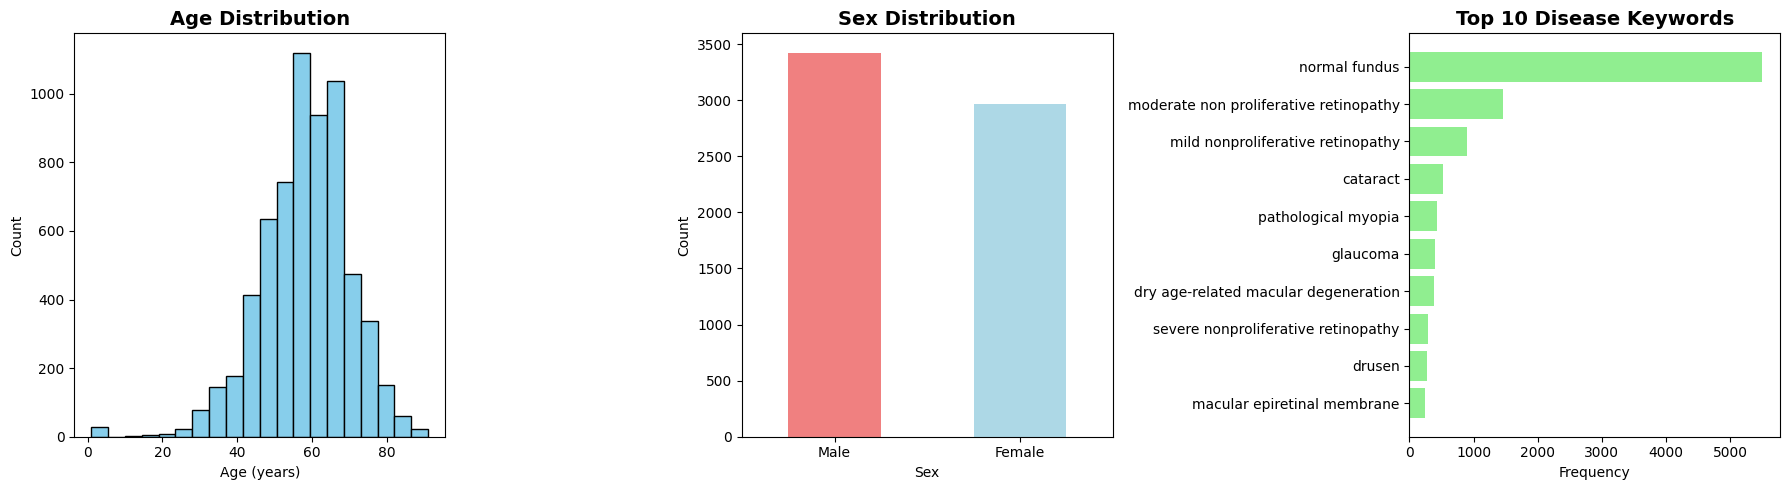


✅ Statistics plot saved to /content/drive/MyDrive/RET-CLIP-ODIR/results/odir_dataset_statistics.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("ODIR-5K DATASET STATISTICS")
print("="*80)

# Age distribution
print(f"\nAge Statistics:")
print(f"  Mean: {odir_df['Patient Age'].mean():.1f} years")
print(f"  Median: {odir_df['Patient Age'].median():.1f} years")
print(f"  Range: {odir_df['Patient Age'].min():.0f} - {odir_df['Patient Age'].max():.0f} years")

# Sex distribution
print(f"\nSex Distribution:")
sex_counts = odir_df['Patient Sex'].value_counts()
for sex, count in sex_counts.items():
    print(f"  {sex}: {count} ({count/len(odir_df)*100:.1f}%)")

# Keywords distribution (top 10 most common)
from collections import Counter

all_keywords = []
for keywords_str in pd.concat([odir_df['Left-Diagnostic Keywords'], odir_df['Right-Diagnostic Keywords']]).dropna():
    all_keywords.extend([k.strip() for k in str(keywords_str).split(',') if k.strip()])

keyword_counts = Counter(all_keywords)
top_keywords = keyword_counts.most_common(10)

print(f"\nTop 10 Disease Keywords:")
for keyword, count in top_keywords:
    print(f"  {keyword}: {count} ({count/(len(odir_df)*2)*100:.1f}%)")

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age distribution
axes[0].hist(odir_df['Patient Age'].dropna(), bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Age Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Count')

# Sex distribution
sex_counts.plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightblue'])
axes[1].set_title('Sex Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

# Top keywords
keywords, counts = zip(*top_keywords)
axes[2].barh(range(len(keywords)), counts, color='lightgreen')
axes[2].set_yticks(range(len(keywords)))
axes[2].set_yticklabels(keywords)
axes[2].set_title('Top 10 Disease Keywords', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Frequency')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig(f"{DRIVE_RESULTS}/odir_dataset_statistics.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Statistics plot saved to {DRIVE_RESULTS}/odir_dataset_statistics.png")

## Cell 2.5: Filter Metadata to Match Available Images

Remove patients from metadata that don't have actual image files.

In [ ]:
print(f"Total metadata rows: {len(odir_df)}")
print(f"Unique patient IDs: {odir_df['ID'].nunique()}")
print(f"Duplicates: {len(odir_df) - odir_df['ID'].nunique()}")

# Show some duplicate IDs
duplicate_ids = odir_df[odir_df.duplicated(subset=['ID'], keep=False)]['ID'].unique()
print(f"\nSample duplicate patient IDs: {duplicate_ids[:10]}")

# Show rows for one duplicate
if len(duplicate_ids) > 0:
    sample_id = duplicate_ids[0]
    print(f"\nRows for patient {sample_id}:")
    print(odir_df[odir_df['ID'] == sample_id])

Total metadata rows: 6392
Unique patient IDs: 3358
Duplicates: 3034

Sample duplicate patient IDs: [ 0  1  4  5  6  7  8  9 10 11]

Rows for patient 0:
      ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0      0           69      Female  0_left.jpg  0_right.jpg   
3194   0           69      Female  0_left.jpg  0_right.jpg   

     Left-Diagnostic Keywords Right-Diagnostic Keywords  N  D  G  C  A  H  M  \
0                    cataract             normal fundus  0  0  0  1  0  0  0   
3194                 cataract             normal fundus  0  0  0  1  0  0  0   

      O                                           filepath labels  \
0     0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
3194  0  ../input/ocular-disease-recognition-odir5k/ODI...  ['C']   

                        target     filename  
0     [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
3194  [0, 0, 0, 1, 0, 0, 0, 0]   0_left.jpg  


In [ ]:

from pathlib import Path
import os

print("="*80)
print("FILTERING METADATA TO MATCH AVAILABLE IMAGES")
print("="*80)

# STEP 1: Remove duplicate patient IDs first!
print(f"Total metadata rows: {len(odir_df)}")
print(f"Unique patient IDs: {odir_df['ID'].nunique()}")
print(f"Duplicates: {len(odir_df) - odir_df['ID'].nunique()}")

# Keep first occurrence of each patient ID
odir_df = odir_df.drop_duplicates(subset=['ID'], keep='first')
print(f"After deduplication: {len(odir_df)} rows\n")

# STEP 2: Get actual image patient IDs from filenames
image_files = list(Path(ODIR_IMAGES_DIR).glob("*_left.jpg"))
image_ids = set()

for img_file in image_files:
    patient_id_str = img_file.stem.replace('_left', '').replace('_LEFT', '')
    try:
        patient_id = int(patient_id_str)
        image_ids.add(patient_id)
    except ValueError:
        print(f"⚠️  Skipping invalid filename: {img_file.name}")

print(f"Image files found: {len(image_ids)} complete pairs")
if image_ids:
    print(f"Image ID range: {min(image_ids)} to {max(image_ids)}")

# STEP 3: Filter to only patients with images
odir_df = odir_df[odir_df['ID'].isin(image_ids)].copy()

print(f"\n✅ Filtered dataset ready:")
print(f"   Patients: {len(odir_df)}")
print(f"   Expected prompts: {len(odir_df) * 3} (3 per patient)")
print(f"   Expected images: {len(odir_df) * 2} (left + right)")

FILTERING METADATA TO MATCH AVAILABLE IMAGES
Total metadata rows: 6392
Unique patient IDs: 3358
Duplicates: 3034
After deduplication: 3358 rows

Image files found: 3198 complete pairs
Image ID range: 0 to 4784

✅ Filtered dataset ready:
   Patients: 3198
   Expected prompts: 9594 (3 per patient)
   Expected images: 6396 (left + right)


# SECTION 3: Generate Clinical Prompts

Use DSPy + OpenRouter to generate 3 clinical prompts per patient:
1. **Left eye prompt**: Specific to left eye pathology
2. **Right eye prompt**: Specific to right eye pathology
3. **Patient-level prompt**: Holistic diagnostic impression (both eyes)

## Cell 3.1: Define ODIR Prompt Signature

In [ ]:
import dspy

class OdirPromptSignature(dspy.Signature):
    """Generate a clinical diagnostic impression for a retinal fundus image with patient metadata.

    Requirements:
    - Use varied medical terminology
    - Be concise (1-2 sentences)
    - Include relevant clinical features when visible
    - Incorporate patient demographics (age, sex) when clinically relevant
    - Vary phrasing to avoid repetition
    - Specify eye laterality (left/right) in the description
    """

    image = dspy.InputField(desc="Color fundus photograph")
    keywords = dspy.InputField(desc="Diagnostic keywords from clinical annotations")
    eye_side = dspy.InputField(desc="Eye laterality: 'left', 'right', or 'both'")
    age = dspy.InputField(desc="Patient age in years")
    sex = dspy.InputField(desc="Patient sex (M/F)")
    style_hint = dspy.InputField(desc="Writing style guidance for variation")

    impression = dspy.OutputField(desc="Clinical diagnostic impression")

print("✅ OdirPromptSignature defined")

✅ OdirPromptSignature defined


In [ ]:
# Filter metadata to only include patients with actual images
print("Filtering metadata to only include patients with images...")

# Get image patient IDs
image_ids = set(int(f.stem.replace('_left', '').replace('_right', ''))
                for f in Path(ODIR_IMAGES_DIR).glob("*_left.jpg"))

# Filter dataframe
odir_df_filtered = odir_df[odir_df['ID'].astype(int).isin(image_ids)].copy()

print(f"Before filtering: {len(odir_df)} patients")
print(f"After filtering: {len(odir_df_filtered)} patients")
print(f"Expected prompts: {len(odir_df_filtered) * 3}")

# Replace the original dataframe
odir_df = odir_df_filtered

Filtering metadata to only include patients with images...
Before filtering: 6392 patients
After filtering: 6232 patients
Expected prompts: 18696


## Cell 3.2: Create ODIR Prompt Generator

In [ ]:
import dspy
import random
from typing import Optional
import re

class OdirPromptGenerator(dspy.Module):
    """Generates varied clinical prompts for ODIR-5K fundus images with metadata."""

    def __init__(self, use_chain_of_thought: bool = False):
        super().__init__()

        # Choose between simple prediction or chain-of-thought
        if use_chain_of_thought:
            self.generate = dspy.ChainOfThought(OdirPromptSignature)
        else:
            self.generate = dspy.Predict(OdirPromptSignature)

        # Style variations for randomization
        self.writing_styles = [
            "formal and detailed",
            "concise and direct",
            "descriptive with key findings",
            "focused on diagnostic features",
            "educational clinical note style",
            "brief assessment format",
        ]

        self.perspectives = [
            "describe visible pathology",
            "summarize diagnostic impression",
            "note clinical significance",
            "describe characteristic findings",
            "identify key abnormalities",
        ]

        self.detail_levels = ["brief", "moderate", "detailed"]

    def _create_style_hint(self, rng: random.Random) -> str:
        """Create a randomized style hint."""
        style = rng.choice(self.writing_styles)
        perspective = rng.choice(self.perspectives)
        detail = rng.choice(self.detail_levels)

        return f"{detail} description, {style}, {perspective}"

    def forward(self, image, keywords: str, eye_side: str, age: int, sex: str,
                rng: Optional[random.Random] = None):
        """Generate a clinical prompt for the given image and metadata."""
        rng = rng or random.Random()

        style_hint = self._create_style_hint(rng)

        result = self.generate(
            image=image,
            keywords=keywords,
            eye_side=eye_side,
            age=age,
            sex=sex,
            style_hint=style_hint
        )

        # Clean up the output
        impression = result.impression.strip()

        # Ensure it ends with a period
        if not impression.endswith(('.', '!', '?')):
            impression += '.'

        # Take only first sentence if multiple were generated
        if '\n' in impression:
            impression = impression.split('\n')[0].strip()

        # Remove model artifacts
        impression = re.sub(r'\s*\[\[\s*##\s*completed\s*##\s*\]\]\.?', '', impression)
        impression = impression.strip()

        # Ensure it still ends with a period after cleanup
        if impression and not impression.endswith(('.', '!', '?')):
            impression += '.'

        return impression

print("✅ OdirPromptGenerator defined")

✅ OdirPromptGenerator defined


## Cell 3.3: Test Generator on Single Patient

In [ ]:
from PIL import Image

# Initialize generator
generator = OdirPromptGenerator(use_chain_of_thought=False)

# Get first patient for testing
test_patient = odir_df.iloc[0]
patient_id = test_patient['ID']
age = int(test_patient['Patient Age'])
sex = test_patient['Patient Sex']
left_keywords = str(test_patient['Left-Diagnostic Keywords'])
right_keywords = str(test_patient['Right-Diagnostic Keywords'])

# Load images from file paths
left_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_left.jpg"
right_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_right.jpg"

if not os.path.exists(left_img_path) or not os.path.exists(right_img_path):
    print(f"❌ Images not found for patient {patient_id}")
    print(f"   Expected: {left_img_path}, {right_img_path}")
    print(f"\n⚠️ Make sure you've downloaded and extracted ODIR-5K images!")
else:
    left_img = Image.open(left_img_path).convert('RGB')
    right_img = Image.open(right_img_path).convert('RGB')

    print(f"Test Patient: {patient_id}")
    print(f"  Age: {age}, Sex: {sex}")
    print(f"  Left Keywords: {left_keywords}")
    print(f"  Right Keywords: {right_keywords}")
    print(f"  Left Image: {left_img.size}")
    print(f"  Right Image: {right_img.size}")

    # Generate 3 prompts
    rng = random.Random(42)

    print("\nGenerating prompts...\n")

    # 1. Left eye prompt
    left_prompt = generator(
        image=left_img,
        keywords=left_keywords,
        eye_side="left",
        age=age,
        sex=sex,
        rng=rng
    )
    print(f"✅ Left Eye Prompt:\n   {left_prompt}\n")

    # 2. Right eye prompt
    right_prompt = generator(
        image=right_img,
        keywords=right_keywords,
        eye_side="right",
        age=age,
        sex=sex,
        rng=rng
    )
    print(f"✅ Right Eye Prompt:\n   {right_prompt}\n")

    # 3. Patient-level prompt (both eyes)
    patient_prompt = generator(
        image=left_img,  # Use either image
        keywords=f"{left_keywords}; {right_keywords}",
        eye_side="both",
        age=age,
        sex=sex,
        rng=rng
    )
    print(f"✅ Patient-Level Prompt:\n   {patient_prompt}\n")

    print("✅ Test generation successful - 3 prompts created per patient")

Test Patient: 0
  Age: 69, Sex: Female
  Left Keywords: cataract
  Right Keywords: normal fundus
  Left Image: (512, 512)
  Right Image: (512, 512)

Generating prompts...

✅ Left Eye Prompt:
   The left fundus shows evidence of cataract, with no other significant findings noted in this 69-year-old female.

✅ Right Eye Prompt:
   The right fundus is normal for a 69-year-old female. No significant abnormalities noted.

✅ Patient-Level Prompt:
   Bilateral cataract is noted. The fundus examination in this 69-year-old female reveals no pathological abnormalities.

✅ Test generation successful - 3 prompts created per patient


## Cell 3.4: Retry Logic for Rate Limiting

In [ ]:
import time

def retry_with_backoff(func, max_retries: int = 5, base_delay: float = 10.0):
    """Enhanced retry function with exponential backoff and better error handling.

    Handles:
    - Rate limiting (429, quota exceeded)
    - Bad requests (400, JSON schema errors)
    - Model unavailability (404, not found)
    """
    for attempt in range(max_retries):
        try:
            return func()
        except Exception as e:
            error_str = str(e).lower()

            # Categorize errors
            is_rate_limit = any(kw in error_str for kw in ["rate limit", "429", "quota", "too many requests"])
            is_bad_request = any(kw in error_str for kw in ["400", "bad request", "json schema"])
            is_not_found = any(kw in error_str for kw in ["404", "not found", "no endpoints"])

            # Don't retry 404 errors - model doesn't exist
            if is_not_found:
                print(f"❌ Model unavailable (404): {error_str[:150]}")
                raise

            # Don't retry JSON schema errors - let DSPy handle fallback
            if is_bad_request and "json schema" in error_str:
                print(f"❌ JSON schema error (will try fallback model)")
                raise

            # Last attempt - give up
            if attempt == max_retries - 1:
                print(f"❌ Max retries ({max_retries}) exhausted")
                raise

            # Calculate backoff delay
            if is_rate_limit:
                delay = base_delay * (2 ** attempt) + random.uniform(0, 5)
                print(f"⏳ Rate limited. Waiting {delay:.1f}s (retry {attempt + 1}/{max_retries})")
            else:
                delay = base_delay + random.uniform(0, 3)
                print(f"⚠️ Error occurred. Waiting {delay:.1f}s (retry {attempt + 1}/{max_retries})")
                print(f"   Error: {error_str[:150]}")

            time.sleep(delay)

print("✅ Retry logic defined")

✅ Retry logic defined


## Cell 3.5: Main Prompt Generation Loop

**⚠️ This will take ~30 minutes for 100 patients (TEST_MODE) or ~4-5 hours for 5,000 patients (FULL_MODE)**

Generates 3 prompts per patient:
- Left eye-specific prompt
- Right eye-specific prompt  
- Patient-level holistic prompt

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
import json
from PIL import Image

# Output paths
prompts_csv_path = f"{DRIVE_PROMPTS}/odir_retclip_prompts.csv"
checkpoint_path = f"{DRIVE_PROMPTS}/generation_checkpoint.json"

# Load checkpoint if exists
processed_patients = set()
prompts_rows = []

if os.path.exists(checkpoint_path):
    with open(checkpoint_path, 'r') as f:
        checkpoint_data = json.load(f)
        processed_patients = set(checkpoint_data.get('processed_patients', []))
        print(f"✅ Resuming from checkpoint: {len(processed_patients)} patients already processed")

    # Load existing prompts
    if os.path.exists(prompts_csv_path):
        existing_df = pd.read_csv(prompts_csv_path)
        prompts_rows = existing_df.to_dict('records')

print(f"\nGenerating prompts for {len(odir_df)} patients...")
print(f"Checkpoint interval: {CHECKPOINT_INTERVAL}")
print(f"Delay between calls: {DELAY_BETWEEN_CALLS}s\n")

# Initialize generator
generator = OdirPromptGenerator(use_chain_of_thought=False)

# Process each patient
for idx, row in tqdm(odir_df.iterrows(), total=len(odir_df), desc="Generating prompts"):
    patient_id = row['ID']

    # Skip if already processed
    if patient_id in processed_patients:
        continue

    try:
        # Load patient metadata
        age = int(row['Patient Age'])
        sex = row['Patient Sex']
        left_keywords = str(row['Left-Diagnostic Keywords'])
        right_keywords = str(row['Right-Diagnostic Keywords'])

        # Load images from file paths
        left_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_left.jpg"
        right_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_right.jpg"

        # This should never happen now since we pre-filtered!
        if not os.path.exists(left_img_path) or not os.path.exists(right_img_path):
            print(f"⚠️ UNEXPECTED: Images not found for patient {patient_id} after filtering!")
            continue

        left_img = Image.open(left_img_path).convert('RGB')
        right_img = Image.open(right_img_path).convert('RGB')

        # Create deterministic RNG based on patient ID
        rng = random.Random(hash(str(patient_id)) ^ 42)

        # Generate 3 prompts with retry logic
        def make_left_prompt():
            return generator(
                image=left_img,
                keywords=left_keywords,
                eye_side="left",
                age=age,
                sex=sex,
                rng=rng
            )

        def make_right_prompt():
            return generator(
                image=right_img,
                keywords=right_keywords,
                eye_side="right",
                age=age,
                sex=sex,
                rng=rng
            )

        def make_patient_prompt():
            return generator(
                image=left_img,
                keywords=f"{left_keywords}; {right_keywords}",
                eye_side="both",
                age=age,
                sex=sex,
                rng=rng
            )

        left_prompt = retry_with_backoff(make_left_prompt)
        time.sleep(DELAY_BETWEEN_CALLS)

        right_prompt = retry_with_backoff(make_right_prompt)
        time.sleep(DELAY_BETWEEN_CALLS)

        patient_prompt = retry_with_backoff(make_patient_prompt)

        # Store results
        prompts_rows.append({
            'patient_id': patient_id,
            'age': age,
            'sex': sex,
            'left_keywords': left_keywords,
            'right_keywords': right_keywords,
            'prompt_left': left_prompt,
            'prompt_right': right_prompt,
            'prompt_patient': patient_prompt
        })

        processed_patients.add(patient_id)

        # Save checkpoint periodically
        if len(processed_patients) % CHECKPOINT_INTERVAL == 0:
            pd.DataFrame(prompts_rows).to_csv(prompts_csv_path, index=False)
            with open(checkpoint_path, 'w') as f:
                json.dump({'processed_patients': list(processed_patients)}, f)

        # Rate limiting
        if idx < len(odir_df) - 1:
            time.sleep(DELAY_BETWEEN_CALLS)

    except Exception as e:
        print(f"\n❌ Error processing patient {patient_id}: {e}")
        # Save checkpoint on error
        pd.DataFrame(prompts_rows).to_csv(prompts_csv_path, index=False)
        with open(checkpoint_path, 'w') as f:
            json.dump({'processed_patients': list(processed_patients)}, f)
        continue

# Save final results
prompts_df = pd.DataFrame(prompts_rows)
prompts_df.to_csv(prompts_csv_path, index=False)

# Clean up checkpoint
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)

print(f"\n✅ Prompt generation complete!")
print(f"   Total patients: {len(prompts_df)}")
print(f"   Total prompts: {len(prompts_df) * 3} (3 per patient)")
print(f"   Saved to: {prompts_csv_path}")


Generating prompts for 6068 patients...
Checkpoint interval: 10
Delay between calls: 0.5s



Generating prompts:   0%|          | 0/6068 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import pandas as pd

print("="*80)
print("VERIFYING PROMPTS DATA")
print("="*80)

# Load prompts CSV
prompts_csv_path = f"{DRIVE_PROMPTS}/odir_retclip_prompts.csv"
prompts_df = pd.read_csv(prompts_csv_path)

print(f"\n📊 Current Status:")
print(f"   odir_df (filtered metadata): {len(odir_df)} patients")
print(f"   prompts_df (CSV): {len(prompts_df)} patients")
print(f"   Match: {len(odir_df) == len(prompts_df)}")

# Check if all odir_df patients have prompts
odir_patient_ids = set(odir_df['ID'].values)
prompts_patient_ids = set(prompts_df['patient_id'].values)

missing_prompts = odir_patient_ids - prompts_patient_ids
extra_prompts = prompts_patient_ids - odir_patient_ids

print(f"\n🔍 Detailed Comparison:")
print(f"   Patients in odir_df: {len(odir_patient_ids)}")
print(f"   Patients in prompts_df: {len(prompts_patient_ids)}")
print(f"   Patients in BOTH: {len(odir_patient_ids & prompts_patient_ids)}")

if missing_prompts:
    print(f"\n⚠️  Patients in odir_df WITHOUT prompts: {len(missing_prompts)}")
    print(f"   Sample IDs: {list(missing_prompts)[:10]}")
else:
    print(f"\n✅ All odir_df patients have prompts!")

if extra_prompts:
    print(f"\n⚠️  Patients in prompts_df NOT in odir_df: {len(extra_prompts)}")
    print(f"   Sample IDs: {list(extra_prompts)[:10]}")
else:
    print(f"✅ No extra prompts!")

# Verify prompt structure
print(f"\n📋 Prompt Structure:")
print(f"   Columns: {list(prompts_df.columns)}")
print(f"   Total prompts: {len(prompts_df) * 3} (3 per patient)")

# Sample check
print(f"\n🔬 Sample Patient Check:")
sample_id = prompts_df['patient_id'].iloc[0]
sample_row = prompts_df[prompts_df['patient_id'] == sample_id].iloc[0]
print(f"   Patient ID: {sample_id}")
print(f"   Has prompt_left: {len(str(sample_row['prompt_left']))} chars")
print(f"   Has prompt_right: {len(str(sample_row['prompt_right']))} chars")
print(f"   Has prompt_patient: {len(str(sample_row['prompt_patient']))} chars")

print(f"\n{'='*80}")
if len(odir_df) == len(prompts_df) and not missing_prompts and not extra_prompts:
    print("✅ PERFECT MATCH! Ready for Section 4!")
else:
    print("⚠️  MISMATCH DETECTED - Need to investigate!")
print(f"{'='*80}")

VERIFYING PROMPTS DATA

📊 Current Status:
   odir_df (filtered metadata): 3034 patients
   prompts_df (CSV): 3034 patients
   Match: True

🔍 Detailed Comparison:
   Patients in odir_df: 3034
   Patients in prompts_df: 3034
   Patients in BOTH: 3034

✅ All odir_df patients have prompts!
✅ No extra prompts!

📋 Prompt Structure:
   Columns: ['patient_id', 'age', 'sex', 'left_keywords', 'right_keywords', 'prompt_left', 'prompt_right', 'prompt_patient']
   Total prompts: 9102 (3 per patient)

🔬 Sample Patient Check:
   Patient ID: 0
   Has prompt_left: 193 chars
   Has prompt_right: 126 chars
   Has prompt_patient: 101 chars

✅ PERFECT MATCH! Ready for Section 4!


In [ ]:
|import shutil
from datetime import datetime

print("="*80)
print("VERIFYING AND BACKING UP PROMPTS")
print("="*80)

prompts_csv_path = f"{DRIVE_PROMPTS}/odir_retclip_prompts.csv"

# Verify file exists and is readable
if os.path.exists(prompts_csv_path):
    try:
        # Try to load it
        verification_df = pd.read_csv(prompts_csv_path)

        print(f"\n✅ CSV file verified:")
        print(f"   Path: {prompts_csv_path}")
        print(f"   Size: {os.path.getsize(prompts_csv_path) / 1024 / 1024:.2f} MB")
        print(f"   Rows: {len(verification_df)}")
        print(f"   Columns: {list(verification_df.columns)}")

        # Verify expected structure
        required_cols = ['patient_id', 'age', 'sex', 'left_keywords', 'right_keywords',
                        'prompt_left', 'prompt_right', 'prompt_patient']
        missing_cols = [col for col in required_cols if col not in verification_df.columns]

        if missing_cols:
            print(f"\n⚠️  WARNING: Missing columns: {missing_cols}")
        else:
            print(f"   ✅ All required columns present")

        # Create timestamped backup
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        backup_path = f"{DRIVE_PROMPTS}/odir_retclip_prompts_backup_{timestamp}.csv"
        shutil.copy2(prompts_csv_path, backup_path)
        print(f"\n✅ Backup created: {backup_path}")

        # Also save as Excel for safety (can be opened manually)
        excel_path = f"{DRIVE_PROMPTS}/odir_retclip_prompts.xlsx"
        verification_df.to_excel(excel_path, index=False)
        print(f"✅ Excel backup created: {excel_path}")

        # Final summary
        print(f"\n📊 FINAL SUMMARY:")
        print(f"   Expected patients: {len(odir_df)}")
        print(f"   Prompts generated: {len(verification_df)}")
        print(f"   Expected prompts: {len(odir_df) * 3}")
        print(f"   Actual prompts: {len(verification_df) * 3}")

        if len(verification_df) == len(odir_df):
            print(f"\n   ✅ ALL PATIENTS HAVE PROMPTS!")
        else:
            missing = len(odir_df) - len(verification_df)
            print(f"\n   ⚠️  MISSING {missing} patients")

    except Exception as e:
        print(f"\n❌ ERROR verifying CSV: {e}")
        print(f"   File may be corrupted!")

else:
    print(f"\n❌ ERROR: CSV file not found at {prompts_csv_path}")
    print(f"   Prompt generation may have failed!")

VERIFYING AND BACKING UP PROMPTS

✅ CSV file verified:
   Path: /content/drive/MyDrive/RET-CLIP-ODIR/prompts/odir_retclip_prompts.csv
   Size: 1.75 MB
   Rows: 3034
   Columns: ['patient_id', 'age', 'sex', 'left_keywords', 'right_keywords', 'prompt_left', 'prompt_right', 'prompt_patient']
   ✅ All required columns present

✅ Backup created: /content/drive/MyDrive/RET-CLIP-ODIR/prompts/odir_retclip_prompts_backup_20251122_224511.csv
✅ Excel backup created: /content/drive/MyDrive/RET-CLIP-ODIR/prompts/odir_retclip_prompts.xlsx

📊 FINAL SUMMARY:
   Expected patients: 6232
   Prompts generated: 3034
   Expected prompts: 18696
   Actual prompts: 9102

   ⚠️  MISSING 3198 patients


# SECTION 4: Preprocess for RET-CLIP

Convert generated prompts and images to RET-CLIP format:
- **TSV**: Real paired left/right images (patient_id, left_img_base64, right_img_base64)
- **JSONL**: Text annotations with eye_side field for tripartite loss

## Cell 4.1: Helper Functions for Image Encoding

In [ ]:
import base64
from io import BytesIO

def image_to_base64_urlsafe(pil_image, size=224):
    """Convert PIL Image to URL-safe base64 string with resizing"""
    if not isinstance(pil_image, Image.Image):
        raise ValueError(f"Expected PIL Image, got {type(pil_image)}")

    # Convert to RGB and resize
    img = pil_image.convert('RGB')
    img = img.resize((size, size), Image.BICUBIC)

    # Encode to base64
    buffered = BytesIO()
    img.save(buffered, format="JPEG", quality=95)
    img_str = base64.urlsafe_b64encode(buffered.getvalue()).decode()
    return img_str

print("✅ Image encoding helper defined")

✅ Image encoding helper defined


## Cell 4.2: Create TSV File (Paired Images)

**Format**: `patient_id\tleft_img_base64\tright_img_base64`

Real binocular pairs - NOT duplicated monocular images!

In [ ]:
from tqdm.notebook import tqdm

# Create TSV file with real paired images
tsv_path = f"{DRIVE_DATA}/odir_train_imgs.tsv"

print(f"Creating TSV file with paired left/right images...")
print(f"Output: {tsv_path}\n")

with open(tsv_path, 'w', encoding='utf-8') as tsv_file:
    for idx, row in tqdm(prompts_df.iterrows(), total=len(prompts_df), desc="Encoding images"):
        patient_id = row['patient_id']

        # Get image paths
        left_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_left.jpg"
        right_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_right.jpg"

        if not os.path.exists(left_img_path) or not os.path.exists(right_img_path):
            print(f"\n⚠️ Images not found for patient {patient_id}")
            continue

        # Load and encode both images separately (real binocular pair!)
        left_img = Image.open(left_img_path)
        right_img = Image.open(right_img_path)

        left_b64 = image_to_base64_urlsafe(left_img, IMAGE_SIZE)
        right_b64 = image_to_base64_urlsafe(right_img, IMAGE_SIZE)

        # Write TSV line: patient_id, left_img, right_img
        tsv_file.write(f"{patient_id}\t{left_b64}\t{right_b64}\n")

print(f"\n✅ TSV file created: {tsv_path}")

# Validate format
with open(tsv_path, 'r', encoding='utf-8') as f:
    first_line = f.readline().strip()
    parts = first_line.split('\t')
    print(f"\nValidation:")
    print(f"  Columns: {len(parts)} (expected: 3)")
    print(f"  Patient ID: {parts[0]}")
    print(f"  Left image length: {len(parts[1])} chars")
    print(f"  Right image length: {len(parts[2])} chars")
    print(f"  ✅ Format correct - Real binocular pairs!")

Creating TSV file with paired left/right images...
Output: /content/drive/MyDrive/RET-CLIP-ODIR/data/odir_train_imgs.tsv



Encoding images:   0%|          | 0/3034 [00:00<?, ?it/s]


✅ TSV file created: /content/drive/MyDrive/RET-CLIP-ODIR/data/odir_train_imgs.tsv

Validation:
  Columns: 3 (expected: 3)
  Patient ID: 0
  Left image length: 12144 chars
  Right image length: 13468 chars
  ✅ Format correct - Real binocular pairs!


## Cell 4.3: Create JSONL File (Text Annotations with Eye Side)

**Format**: Each patient generates 3 JSONL entries:
```json
{"text_id": 0, "text": "left prompt", "image_ids": ["patient_id"], "eye_side": "left"}
{"text_id": 1, "text": "right prompt", "image_ids": ["patient_id"], "eye_side": "right"}
{"text_id": 2, "text": "patient prompt", "image_ids": ["patient_id"], "eye_side": "both"}
```

The `eye_side` field is used by RET-CLIP's tripartite loss function.

In [ ]:
import json

# Create JSONL file with text annotations and eye_side field
jsonl_path = f"{DRIVE_DATA}/odir_train_texts.jsonl"

print(f"Creating JSONL file with eye_side annotations...")
print(f"Output: {jsonl_path}\n")

text_id = 0
with open(jsonl_path, 'w', encoding='utf-8') as jsonl_file:
    for idx, row in tqdm(prompts_df.iterrows(), total=len(prompts_df), desc="Writing JSONL"):
        patient_id = row['patient_id']

        # Entry 1: Left eye prompt
        left_entry = {
            "text_id": text_id,
            "text": row['prompt_left'],
            "image_ids": [patient_id],
            "eye_side": "left"
        }
        jsonl_file.write(json.dumps(left_entry, ensure_ascii=False) + '\n')
        text_id += 1

        # Entry 2: Right eye prompt
        right_entry = {
            "text_id": text_id,
            "text": row['prompt_right'],
            "image_ids": [patient_id],
            "eye_side": "right"
        }
        jsonl_file.write(json.dumps(right_entry, ensure_ascii=False) + '\n')
        text_id += 1

        # Entry 3: Patient-level prompt (both eyes)
        patient_entry = {
            "text_id": text_id,
            "text": row['prompt_patient'],
            "image_ids": [patient_id],
            "eye_side": "both"
        }
        jsonl_file.write(json.dumps(patient_entry, ensure_ascii=False) + '\n')
        text_id += 1

print(f"\n✅ JSONL file created: {jsonl_path}")
print(f"   Total patients: {len(prompts_df)}")
print(f"   Total text entries: {text_id} (3 per patient)")

# Validate format
with open(jsonl_path, 'r', encoding='utf-8') as f:
    sample_lines = [json.loads(f.readline()) for _ in range(3)]

print(f"\nValidation - First patient's 3 prompts:")
for entry in sample_lines:
    print(f"  [{entry['eye_side']}] {entry['text'][:80]}...")

print(f"\n✅ Format correct - 3 prompts per patient with eye_side annotations!")

Creating JSONL file with eye_side annotations...
Output: /content/drive/MyDrive/RET-CLIP-ODIR/data/odir_train_texts.jsonl



Writing JSONL:   0%|          | 0/3034 [00:00<?, ?it/s]


✅ JSONL file created: /content/drive/MyDrive/RET-CLIP-ODIR/data/odir_train_texts.jsonl
   Total patients: 3034
   Total text entries: 9102 (3 per patient)

Validation - First patient's 3 prompts:
  [left] The left fundus examination of this 69-year-old female reveals a dense cataract,...
  [right] The right fundus of this 69-year-old female demonstrates a normal appearance wit...
  [both] Bilateral cataracts are noted in this 69-year-old female, with the fundus otherw...

✅ Format correct - 3 prompts per patient with eye_side annotations!


## Cell 4.4: Train/Test Split

Split the prompts into training and testing sets (80/20 split).

In [ ]:
from sklearn.model_selection import train_test_split

print("="*80)
print("SPLITTING DATA INTO TRAIN/TEST SETS")
print("="*80)

# Split prompts DataFrame (80/20 split)
train_df, test_df = train_test_split(
    prompts_df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"\nTrain patients: {len(train_df)} ({len(train_df)/len(prompts_df)*100:.1f}%)")
print(f"Test patients: {len(test_df)} ({len(test_df)/len(prompts_df)*100:.1f}%)")
print(f"\nTrain prompts: {len(train_df) * 3}")
print(f"Test prompts: {len(test_df) * 3}")

# Save splits for reference
train_df.to_csv(f"{DRIVE_DATA}/train_patients.csv", index=False)
test_df.to_csv(f"{DRIVE_DATA}/test_patients.csv", index=False)

print(f"\n✅ Splits saved:")
print(f"   {DRIVE_DATA}/train_patients.csv")
print(f"   {DRIVE_DATA}/test_patients.csv")

SPLITTING DATA INTO TRAIN/TEST SETS

Train patients: 2427 (80.0%)
Test patients: 607 (20.0%)

Train prompts: 7281
Test prompts: 1821

✅ Splits saved:
   /content/drive/MyDrive/RET-CLIP-ODIR/data/train_patients.csv
   /content/drive/MyDrive/RET-CLIP-ODIR/data/test_patients.csv


## Cell 4.5: Create Train TSV and JSONL Files

In [ ]:
# Create Train TSV file
tsv_path = f"{DRIVE_DATA}/train_imgs.tsv"  # FIXED: removed "odir_" prefix

print(f"Creating TRAIN TSV file...")
print(f"Output: {tsv_path}\n")

with open(tsv_path, 'w', encoding='utf-8') as tsv_file:
    for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Encoding train images"):
        patient_id = row['patient_id']

        # Get image paths
        left_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_left.jpg"
        right_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_right.jpg"

        if not os.path.exists(left_img_path) or not os.path.exists(right_img_path):
            continue

        # Load and encode both images
        left_img = Image.open(left_img_path)
        right_img = Image.open(right_img_path)

        left_b64 = image_to_base64_urlsafe(left_img, IMAGE_SIZE)
        right_b64 = image_to_base64_urlsafe(right_img, IMAGE_SIZE)

        tsv_file.write(f"{patient_id}\t{left_b64}\t{right_b64}\n")

print(f"\n✅ Train TSV created: {tsv_path}")

# Create Train JSONL file
jsonl_path = f"{DRIVE_DATA}/train_texts.jsonl"  # FIXED: removed "odir_" prefix

print(f"\nCreating TRAIN JSONL file...")
print(f"Output: {jsonl_path}\n")

text_id = 0
with open(jsonl_path, 'w', encoding='utf-8') as jsonl_file:
    for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Writing train JSONL"):
        patient_id = row['patient_id']

        # Entry 1: Left eye prompt
        left_entry = {
            "text_id": text_id,
            "text": row['prompt_left'],
            "image_ids": [patient_id],
            "eye_side": "left"
        }
        jsonl_file.write(json.dumps(left_entry, ensure_ascii=False) + '\n')
        text_id += 1

        # Entry 2: Right eye prompt
        right_entry = {
            "text_id": text_id,
            "text": row['prompt_right'],
            "image_ids": [patient_id],
            "eye_side": "right"
        }
        jsonl_file.write(json.dumps(right_entry, ensure_ascii=False) + '\n')
        text_id += 1

        # Entry 3: Patient-level prompt
        patient_entry = {
            "text_id": text_id,
            "text": row['prompt_patient'],
            "image_ids": [patient_id],
            "eye_side": "both"
        }
        jsonl_file.write(json.dumps(patient_entry, ensure_ascii=False) + '\n')
        text_id += 1

print(f"\n✅ Train JSONL created: {jsonl_path}")
print(f"   Total text entries: {text_id} (3 per patient)")

Creating TRAIN TSV file...
Output: /content/drive/MyDrive/RET-CLIP-ODIR/data/train_imgs.tsv



Encoding train images:   0%|          | 0/2427 [00:00<?, ?it/s]


✅ Train TSV created: /content/drive/MyDrive/RET-CLIP-ODIR/data/train_imgs.tsv

Creating TRAIN JSONL file...
Output: /content/drive/MyDrive/RET-CLIP-ODIR/data/train_texts.jsonl



Writing train JSONL:   0%|          | 0/2427 [00:00<?, ?it/s]


✅ Train JSONL created: /content/drive/MyDrive/RET-CLIP-ODIR/data/train_texts.jsonl
   Total text entries: 7281 (3 per patient)


## Cell 4.6: Create Test TSV and JSONL Files

In [ ]:
# Create Test TSV file
tsv_path = f"{DRIVE_DATA}/test_imgs.tsv"  # FIXED: removed "odir_" prefix

print(f"Creating TEST TSV file...")
print(f"Output: {tsv_path}\n")

with open(tsv_path, 'w', encoding='utf-8') as tsv_file:
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Encoding test images"):
        patient_id = row['patient_id']

        # Get image paths
        left_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_left.jpg"
        right_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_right.jpg"

        if not os.path.exists(left_img_path) or not os.path.exists(right_img_path):
            continue

        # Load and encode both images
        left_img = Image.open(left_img_path)
        right_img = Image.open(right_img_path)

        left_b64 = image_to_base64_urlsafe(left_img, IMAGE_SIZE)
        right_b64 = image_to_base64_urlsafe(right_img, IMAGE_SIZE)

        tsv_file.write(f"{patient_id}\t{left_b64}\t{right_b64}\n")

print(f"\n✅ Test TSV created: {tsv_path}")

# Create Test JSONL file
jsonl_path = f"{DRIVE_DATA}/test_texts.jsonl"  # FIXED: removed "odir_" prefix

print(f"\nCreating TEST JSONL file...")
print(f"Output: {jsonl_path}\n")

text_id = 0
with open(jsonl_path, 'w', encoding='utf-8') as jsonl_file:
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Writing test JSONL"):
        patient_id = row['patient_id']

        # Entry 1: Left eye prompt
        left_entry = {
            "text_id": text_id,
            "text": row['prompt_left'],
            "image_ids": [patient_id],
            "eye_side": "left"
        }
        jsonl_file.write(json.dumps(left_entry, ensure_ascii=False) + '\n')
        text_id += 1

        # Entry 2: Right eye prompt
        right_entry = {
            "text_id": text_id,
            "text": row['prompt_right'],
            "image_ids": [patient_id],
            "eye_side": "right"
        }
        jsonl_file.write(json.dumps(right_entry, ensure_ascii=False) + '\n')
        text_id += 1

        # Entry 3: Patient-level prompt
        patient_entry = {
            "text_id": text_id,
            "text": row['prompt_patient'],
            "image_ids": [patient_id],
            "eye_side": "both"
        }
        jsonl_file.write(json.dumps(patient_entry, ensure_ascii=False) + '\n')
        text_id += 1

print(f"\n✅ Test JSONL created: {jsonl_path}")
print(f"   Total text entries: {text_id} (3 per patient)")

Creating TEST TSV file...
Output: /content/drive/MyDrive/RET-CLIP-ODIR/data/test_imgs.tsv



Encoding test images:   0%|          | 0/607 [00:00<?, ?it/s]


✅ Test TSV created: /content/drive/MyDrive/RET-CLIP-ODIR/data/test_imgs.tsv

Creating TEST JSONL file...
Output: /content/drive/MyDrive/RET-CLIP-ODIR/data/test_texts.jsonl



Writing test JSONL:   0%|          | 0/607 [00:00<?, ?it/s]


✅ Test JSONL created: /content/drive/MyDrive/RET-CLIP-ODIR/data/test_texts.jsonl
   Total text entries: 1821 (3 per patient)


# SECTION 5: Build LMDB Database

Create LMDB databases for efficient data loading during training.

LMDB (Lightning Memory-Mapped Database) is a high-performance embedded database that allows fast random access to image data during training.

## Cell 5.1: Build Train LMDB

In [ ]:
# Build LMDB for train set
print("="*80)
print("Building LMDB for TRAIN set")
print("="*80)

!python /content/retclip/RET_CLIP/preprocess/build_lmdb_dataset_for_RET-CLIP.py \
    --data_dir {DRIVE_DATA} \
    --splits train \
    --lmdb_dir {DRIVE_LMDB}

Building LMDB for TRAIN set
Dataset splits to be processed: train
We will overwrite an existing LMDB file /content/drive/MyDrive/RET-CLIP-ODIR/lmdb/train
7281it [00:00, 59938.15it/s]
Finished serializing 7281 train split pairs into /content/drive/MyDrive/RET-CLIP-ODIR/lmdb/train/pairs.
2427it [00:07, 321.56it/s]
Finished serializing 2427 train split images into /content/drive/MyDrive/RET-CLIP-ODIR/lmdb/train/imgs.
done!


## Cell 5.2: Build Test LMDB

In [ ]:
# Build LMDB for test set
print("\n" + "="*80)
print("Building LMDB for TEST set")
print("="*80)

!python /content/retclip/RET_CLIP/preprocess/build_lmdb_dataset_for_RET-CLIP.py \
    --data_dir {DRIVE_DATA} \
    --splits test \
    --lmdb_dir {DRIVE_LMDB}


Building LMDB for TEST set
Dataset splits to be processed: test
We will overwrite an existing LMDB file /content/drive/MyDrive/RET-CLIP-ODIR/lmdb/test
1821it [00:00, 145385.51it/s]
Finished serializing 1821 test split pairs into /content/drive/MyDrive/RET-CLIP-ODIR/lmdb/test/pairs.
607it [00:00, 8214.31it/s]
Finished serializing 607 test split images into /content/drive/MyDrive/RET-CLIP-ODIR/lmdb/test/imgs.
done!


## Cell 5.3: Validate LMDB Databases

In [ ]:
# Validate LMDB by reading a few samples
import lmdb
import pickle

print("\n" + "="*80)
print("Validating LMDB databases")
print("="*80)

for split_name in ['train', 'test']:
    lmdb_path = f"{DRIVE_LMDB}/{split_name}/imgs"

    if not os.path.exists(lmdb_path):
        print(f"❌ LMDB not found: {lmdb_path}")
        continue

    env = lmdb.open(lmdb_path, readonly=True, lock=False, readahead=False, meminit=False)

    with env.begin() as txn:
        # Try to read first 3 samples
        print(f"\n{split_name.upper()} LMDB:")

        # Get list of patient IDs from the corresponding dataframe
        if split_name == 'train':
            sample_ids = train_df['patient_id'].head(3).tolist()
        else:
            sample_ids = test_df['patient_id'].head(3).tolist()

        for patient_id in sample_ids:
            # FIXED: Convert patient_id to string before encoding
            value = txn.get(str(patient_id).encode('utf-8'))

            if value is None:
                print(f"  ⚠️ No data for {patient_id}")
                continue

            try:
                img_left_b64, img_right_b64 = pickle.loads(value)
                print(f"  ✅ {patient_id}: left={len(img_left_b64)} chars, right={len(img_right_b64)} chars")
            except Exception as e:
                print(f"  ❌ Error unpacking {patient_id}: {e}")

    env.close()

print("\n✅ LMDB validation complete")


Validating LMDB databases

TRAIN LMDB:
  ✅ 521: left=15880 chars, right=18628 chars
  ✅ 4234: left=19880 chars, right=19788 chars
  ✅ 1386: left=14916 chars, right=15472 chars

TEST LMDB:
  ✅ 4499: left=19000 chars, right=21780 chars
  ✅ 3211: left=20100 chars, right=18444 chars
  ✅ 3426: left=15124 chars, right=14848 chars

✅ LMDB validation complete


# SECTION 6: Train RET-CLIP

Train RET-CLIP using contrastive learning on the ODIR-5K dataset with English PubMedBERT text encoder.

**Expected Time**:
- TEST MODE (100 patients, 2 epochs): ~30 minutes on T4
- FULL MODE (5,000 patients, 10 epochs): ~12-15 hours on A100

## Cell 6.1: Training Configuration

In [ ]:
# Display training configuration
print("="*80)
print("TRAINING CONFIGURATION")
print("="*80)
print(f"  Mode: {'TEST' if TEST_MODE else 'FULL'}")
print(f"  Vision Model: {VISION_MODEL}")
print(f"  Text Model: {TEXT_MODEL}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Warmup Steps: {WARMUP_STEPS}")
print(f"   ⭐ CLIP Pretrained: {CLIP_WEIGHT_PATH}")
print(f"   ⭐ BERT Pretrained: {BERT_WEIGHT_PATH}")
print(f"  Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Train samples: {len(train_df)}")
print(f"  Test samples: {len(test_df)}")
print(f"  LMDB dir: {DRIVE_LMDB}/train")
print(f"  Checkpoint dir: {DRIVE_CHECKPOINTS}")
print("\n💡 Note: Using PubMedBERT (medical domain-specific text encoder)")
print("✅ Configuration ready for training")

TRAINING CONFIGURATION
  Mode: FULL
  Vision Model: ViT-B-16
  Text Model: microsoft-BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
  Batch Size: 256
  Epochs: 20
  Learning Rate: 0.0011
  Warmup Steps: 50
   ⭐ CLIP Pretrained: /content/drive/MyDrive/RET-CLIP-ODIR/pretrained_weights/openai_vit_b_16.pt
   ⭐ BERT Pretrained: /content/drive/MyDrive/RET-CLIP-ODIR/pretrained_weights/pubmedbert_base.pt
  Image Size: 224x224
  Train samples: 2427
  Test samples: 607
  LMDB dir: /content/drive/MyDrive/RET-CLIP-ODIR/lmdb/train
  Checkpoint dir: /content/drive/MyDrive/RET-CLIP-ODIR/checkpoints

💡 Note: Using PubMedBERT (medical domain-specific text encoder)
✅ Configuration ready for training


In [ ]:
print("\n" + "="*80)
print("DOWNLOADING AND PREPARING PRETRAINED WEIGHTS")
print("="*80)

import torch
import clip as openai_clip  # OpenAI's official CLIP
from transformers import AutoModel

# Create weights directory
DRIVE_WEIGHTS = f"{DRIVE_BASE}/pretrained_weights"
os.makedirs(DRIVE_WEIGHTS, exist_ok=True)

# ============================================================================
# STEP 1: Download OpenAI CLIP ViT-B/16 Weights
# ============================================================================
print("\n📥 Downloading OpenAI CLIP ViT-B/16...")

# Download using OpenAI's official CLIP library
openai_model, preprocess = openai_clip.load("ViT-B/16", device="cpu")

# Extract vision encoder weights
clip_state_dict = openai_model.state_dict()

# Save in RET-CLIP compatible format
CLIP_WEIGHT_PATH = f"{DRIVE_WEIGHTS}/openai_vit_b_16.pt"
torch.save(clip_state_dict, CLIP_WEIGHT_PATH)

print(f"✅ Saved OpenAI CLIP weights to: {CLIP_WEIGHT_PATH}")
print(f"   Vision encoder: ViT-B/16")
print(f"   Size: {os.path.getsize(CLIP_WEIGHT_PATH) / 1024 / 1024:.1f} MB")

del openai_model, clip_state_dict
torch.cuda.empty_cache()

# ============================================================================
# STEP 2: Download PubMedBERT Weights from HuggingFace
# ============================================================================
print(f"\n📥 Downloading PubMedBERT from HuggingFace...")

# Download the exact model you're using for text encoding
bert_model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
bert_model = AutoModel.from_pretrained(bert_model_name)

# Extract BERT state dict
bert_state_dict = bert_model.state_dict()

# Add 'bert.' prefix to match RET-CLIP's expected format
bert_state_dict_prefixed = {}
for k, v in bert_state_dict.items():
    # Skip pooler layer (RET-CLIP doesn't use it)
    if "pooler" not in k:
        bert_state_dict_prefixed[f"bert.{k}"] = v

# Save in RET-CLIP compatible format
BERT_WEIGHT_PATH = f"{DRIVE_WEIGHTS}/pubmedbert_base.pt"
torch.save(bert_state_dict_prefixed, BERT_WEIGHT_PATH)

print(f"✅ Saved PubMedBERT weights to: {BERT_WEIGHT_PATH}")
print(f"   Text encoder: {bert_model_name}")
print(f"   Size: {os.path.getsize(BERT_WEIGHT_PATH) / 1024 / 1024:.1f} MB")

del bert_model, bert_state_dict, bert_state_dict_prefixed
torch.cuda.empty_cache()

# ============================================================================
# STEP 3: Verify Weight Files
# ============================================================================
print(f"\n" + "="*80)
print("VERIFICATION")
print("="*80)

print(f"\n✅ Pretrained weights ready:")
print(f"   CLIP:  {CLIP_WEIGHT_PATH}")
print(f"   BERT:  {BERT_WEIGHT_PATH}")

# Test loading
print(f"\n🔍 Testing weight loading...")
clip_test = torch.load(CLIP_WEIGHT_PATH, map_location="cpu", weights_only=False)
bert_test = torch.load(BERT_WEIGHT_PATH, map_location="cpu", weights_only=False)

print(f"   CLIP keys: {len(clip_test)} layers")
print(f"   BERT keys: {len(bert_test)} layers")
print(f"   Sample CLIP key: {list(clip_test.keys())[0]}")
print(f"   Sample BERT key: {list(bert_test.keys())[0]}")

del clip_test, bert_test

print(f"\n✅ All checks passed! Ready for training with pretrained weights.")
print(f"\n" + "="*80)


DOWNLOADING AND PREPARING PRETRAINED WEIGHTS

📥 Downloading OpenAI CLIP ViT-B/16...


100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 315MiB/s]


✅ Saved OpenAI CLIP weights to: /content/drive/MyDrive/RET-CLIP-ODIR/pretrained_weights/openai_vit_b_16.pt
   Vision encoder: ViT-B/16
   Size: 570.9 MB

📥 Downloading PubMedBERT from HuggingFace...


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

✅ Saved PubMedBERT weights to: /content/drive/MyDrive/RET-CLIP-ODIR/pretrained_weights/pubmedbert_base.pt
   Text encoder: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
   Size: 415.5 MB

VERIFICATION

✅ Pretrained weights ready:
   CLIP:  /content/drive/MyDrive/RET-CLIP-ODIR/pretrained_weights/openai_vit_b_16.pt
   BERT:  /content/drive/MyDrive/RET-CLIP-ODIR/pretrained_weights/pubmedbert_base.pt

🔍 Testing weight loading...
   CLIP keys: 302 layers
   BERT keys: 197 layers
   Sample CLIP key: positional_embedding
   Sample BERT key: bert.embeddings.word_embeddings.weight

✅ All checks passed! Ready for training with pretrained weights.



In [ ]:
import torch

# Load the epoch 1 checkpoint
checkpoint_path = f"{DRIVE_CHECKPOINTS}/{model_name}/checkpoints/epoch1.pt"
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

state_dict = checkpoint['state_dict']

# Check a specific vision encoder weight
sample_vision_key = 'module.visual.conv1.weight'
if sample_vision_key in state_dict:
    vision_weight = state_dict[sample_vision_key]
    print(f"Vision encoder weight mean: {vision_weight.mean():.6f}")
    print(f"Vision encoder weight std: {vision_weight.std():.6f}")
    print(f"Vision encoder weight shape: {vision_weight.shape}")
else:
    print("Vision weight not found!")

# Check a BERT weight
sample_bert_key = 'module.bert.embeddings.word_embeddings.weight'
if sample_bert_key in state_dict:
    bert_weight = state_dict[sample_bert_key]
    print(f"\nBERT weight mean: {bert_weight.mean():.6f}")
    print(f"BERT weight std: {bert_weight.std():.6f}")
    print(f"BERT weight shape: {bert_weight.shape}")
else:
    print("BERT weight not found!")

Vision encoder weight mean: 0.000052
Vision encoder weight std: 0.018974
Vision encoder weight shape: torch.Size([768, 3, 16, 16])

BERT weight mean: -0.008072
BERT weight std: 0.078548
BERT weight shape: torch.Size([30522, 768])


In [ ]:
import torch

print("Checking weight file contents:")
print("="*80)

# Check CLIP weights
clip_weights = torch.load(CLIP_WEIGHT_PATH, map_location="cpu", weights_only=False)
print(f"\n📁 CLIP weights ({CLIP_WEIGHT_PATH}):")
print(f"   Total keys: {len(clip_weights)}")
print(f"   Sample keys:")
for i, key in enumerate(list(clip_weights.keys())[:10]):
    print(f"      {i+1}. {key}")

# Check how many start with "visual" (what RET-CLIP expects)
visual_keys = [k for k in clip_weights.keys() if k.startswith("visual")]
print(f"\n   Keys starting with 'visual': {len(visual_keys)}")
if len(visual_keys) == 0:
    print("   ⚠️  WARNING: No 'visual' keys found! RET-CLIP won't load these!")

print("\n" + "="*80)

# Check BERT weights
bert_weights = torch.load(BERT_WEIGHT_PATH, map_location="cpu", weights_only=False)
print(f"\n📁 BERT weights ({BERT_WEIGHT_PATH}):")
print(f"   Total keys: {len(bert_weights)}")
print(f"   Sample keys:")
for i, key in enumerate(list(bert_weights.keys())[:10]):
    print(f"      {i+1}. {key}")

# Check how many start with "bert" (what RET-CLIP expects)
bert_keys = [k for k in bert_weights.keys() if k.startswith("bert")]
print(f"\n   Keys starting with 'bert': {len(bert_keys)}")
if len(bert_keys) == 0:
    print("   ⚠️  WARNING: No 'bert' keys found! RET-CLIP won't load these!")

print("\n" + "="*80)

Checking weight file contents:

📁 CLIP weights (/content/drive/MyDrive/RET-CLIP-ODIR/pretrained_weights/openai_vit_b_16.pt):
   Total keys: 302
   Sample keys:
      1. positional_embedding
      2. text_projection
      3. logit_scale
      4. visual.class_embedding
      5. visual.positional_embedding
      6. visual.proj
      7. visual.conv1.weight
      8. visual.ln_pre.weight
      9. visual.ln_pre.bias
      10. visual.transformer.resblocks.0.attn.in_proj_weight

   Keys starting with 'visual': 152


📁 BERT weights (/content/drive/MyDrive/RET-CLIP-ODIR/pretrained_weights/pubmedbert_base.pt):
   Total keys: 197
   Sample keys:
      1. bert.embeddings.word_embeddings.weight
      2. bert.embeddings.position_embeddings.weight
      3. bert.embeddings.token_type_embeddings.weight
      4. bert.embeddings.LayerNorm.weight
      5. bert.embeddings.LayerNorm.bias
      6. bert.encoder.layer.0.attention.self.query.weight
      7. bert.encoder.layer.0.attention.self.query.bias
      8. 

## Cell 6.2: Run Training with torchrun

**⚠️ This will take ~30 minutes for TEST_MODE or ~12-15 hours for FULL_MODE**

Trains RET-CLIP with:
- Distributed data parallel (DDP) even on single GPU for efficiency
- Checkpoints saved every epoch to Google Drive
- Uses tripartite contrastive loss for binocular architecture

In [ ]:
RUN_TEXT_ENCODER_COMPARISON = True

In [ ]:
type(BATCH_SIZE)

int

In [ ]:
os.environ['PYTHONPATH'] = '/content/retclip'
print(f"✅ Set PYTHONPATH to: {os.environ['PYTHONPATH']}")

✅ Set PYTHONPATH to: /content/retclip


In [ ]:
# Set PYTHONPATH for subprocess
import os
os.environ['PYTHONPATH'] = '/content/retclip'
print(f"✅ Set PYTHONPATH to: {os.environ['PYTHONPATH']}")

# Determine which text encoders to train
if RUN_TEXT_ENCODER_COMPARISON:
    encoders_to_train = TEXT_ENCODERS
    print(f"\n✅ TEXT ENCODER COMPARISON MODE: Will train {len(encoders_to_train)} models")
else:
    # Train only the default TEXT_MODEL
    encoders_to_train = [{
        "name": "PubMedBERT",
        "model_id": TEXT_MODEL,
        "description": "Default text encoder"
    }]
    print(f"\n✅ SINGLE ENCODER MODE: Training only {TEXT_MODEL}")

# Train each text encoder
for encoder_idx, encoder_config in enumerate(encoders_to_train):
    encoder_name = encoder_config["name"]
    encoder_model_id = encoder_config["model_id"]
    encoder_desc = encoder_config["description"]

    # Create encoder-specific name for checkpoints
    encoder_short_name = encoder_name.lower().replace('-', '').replace(' ', '')
    model_name = f"retclip_odir_{encoder_short_name}"

    # Check if model already trained (checkpoint exists)
    checkpoint_dir = f"{DRIVE_CHECKPOINTS}/{model_name}/checkpoints"
    if os.path.exists(checkpoint_dir) and len(os.listdir(checkpoint_dir)) > 0:
        print("\n" + "="*80)
        print(f"⏭️  SKIPPING Model {encoder_idx + 1}/{len(encoders_to_train)}: {encoder_name}")
        print("="*80)
        print(f"  ✅ Checkpoints already exist at: {checkpoint_dir}")
        print(f"  Found {len(os.listdir(checkpoint_dir))} checkpoint files")
        print("="*80)
        continue

    print("\n" + "="*80)
    print(f"Training Model {encoder_idx + 1}/{len(encoders_to_train)}: {encoder_name}")
    print("="*80)
    print(f"  Description: {encoder_desc}")
    print(f"  Model ID: {encoder_model_id}")
    print(f"  Vision Model: {VISION_MODEL}")
    print(f"  Epochs: {NUM_EPOCHS}")
    print(f"  Batch Size: {BATCH_SIZE}")
    print(f"  Checkpoint Name: {model_name}")
    print("="*80)

    cmd = f"torchrun --nproc_per_node=1 --master_port=29500 " \
          f"/content/retclip/RET_CLIP/training/main.py " \
          f"--train-data {DRIVE_LMDB}/train " \
          f"--batch-size {BATCH_SIZE} " \
          f"--max-epochs {NUM_EPOCHS} " \
          f"--lr {LEARNING_RATE} " \
          f"--warmup {WARMUP_STEPS} " \
          f"--vision-model {VISION_MODEL} " \
          f"--text-model {encoder_model_id} " \
          f"--logs {DRIVE_CHECKPOINTS} " \
          f"--name {model_name} " \
          f"--save-epoch-frequency 1 " \
          f"--skip-aggregate " \
          f"--clip-weight-path {CLIP_WEIGHT_PATH} " \
          f"--wd 0.001 " \
          f"--num-workers 4 " \
          f"--report-training-batch-acc"

    # Only add bert-weight-path for compatible models (NOT BioBERT - different vocab size)
    if encoder_model_id != "dmis-lab-biobert-base-cased-v1.1":
        cmd += f" --bert-weight-path {BERT_WEIGHT_PATH}"

    !{cmd}

    print(f"\n✅ Completed training for {encoder_name}")
    print(f"   Checkpoints saved to: {DRIVE_CHECKPOINTS}/{model_name}/checkpoints/")

    if encoder_idx < len(encoders_to_train) - 1:
        print(f"\n⏳ Moving to next encoder...")

print("\n" + "="*80)
print("🎉 ALL TRAINING COMPLETE!")
print("="*80)
if RUN_TEXT_ENCODER_COMPARISON:
    print(f"Trained {len(encoders_to_train)} models:")
    for encoder_config in encoders_to_train:
        encoder_short_name = encoder_config["name"].lower().replace('-', '').replace(' ', '')
        print(f"  ✅ retclip_odir_{encoder_short_name}")
else:
    print(f"Trained 1 model: retclip_odir_pubmedbert")

✅ Set PYTHONPATH to: /content/retclip

✅ TEXT ENCODER COMPARISON MODE: Will train 3 models

⏭️  SKIPPING Model 1/3: PubMedBERT
  ✅ Checkpoints already exist at: /content/drive/MyDrive/RET-CLIP-ODIR/checkpoints/retclip_odir_pubmedbert/checkpoints
  Found 21 checkpoint files

⏭️  SKIPPING Model 2/3: BERT-base
  ✅ Checkpoints already exist at: /content/drive/MyDrive/RET-CLIP-ODIR/checkpoints/retclip_odir_bertbase/checkpoints
  Found 21 checkpoint files

⏭️  SKIPPING Model 3/3: BioBERT
  ✅ Checkpoints already exist at: /content/drive/MyDrive/RET-CLIP-ODIR/checkpoints/retclip_odir_biobert/checkpoints
  Found 20 checkpoint files

🎉 ALL TRAINING COMPLETE!
Trained 3 models:
  ✅ retclip_odir_pubmedbert
  ✅ retclip_odir_bertbase
  ✅ retclip_odir_biobert


## Cell 6.3: Verify Saved Checkpoints

In [ ]:
# List saved checkpoints for all trained models
print("\n" + "="*80)
print("Saved Checkpoints")
print("="*80)

# Determine which models were trained
if RUN_TEXT_ENCODER_COMPARISON:
    model_names = [f"retclip_odir_{enc['name'].lower().replace('-', '').replace(' ', '')}" for enc in TEXT_ENCODERS]
else:
    model_names = ["retclip_odir_pubmedbert"]

for model_name in model_names:
    checkpoint_dir = f"{DRIVE_CHECKPOINTS}/{model_name}/checkpoints"

    print(f"\n📁 {model_name}:")

    if os.path.exists(checkpoint_dir):
        checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')])

        if checkpoint_files:
            print(f"   ✅ Found {len(checkpoint_files)} checkpoint(s):")
            for ckpt in checkpoint_files:
                ckpt_path = f"{checkpoint_dir}/{ckpt}"
                size_mb = os.path.getsize(ckpt_path) / (1024 * 1024)
                print(f"      {ckpt} ({size_mb:.1f} MB)")

            # Verify final checkpoint exists
            final_checkpoint = f"{checkpoint_dir}/epoch_latest.pt"
            if os.path.exists(final_checkpoint):
                print(f"   ✅ Final checkpoint ready: epoch_latest.pt")
            else:
                print(f"   ⚠️ Final checkpoint not found: epoch_latest.pt")
        else:
            print(f"   ❌ No .pt files found")
    else:
        print(f"   ❌ Directory not found: {checkpoint_dir}")

print("\n" + "="*80)
print("Checkpoint Verification Complete")
print("="*80)


Saved Checkpoints

📁 retclip_odir_pubmedbert:
   ✅ Found 21 checkpoint(s):
      epoch1.pt (2278.8 MB)
      epoch10.pt (2278.8 MB)
      epoch11.pt (2278.8 MB)
      epoch12.pt (2278.8 MB)
      epoch13.pt (2278.8 MB)
      epoch14.pt (2278.8 MB)
      epoch15.pt (2278.8 MB)
      epoch16.pt (2278.8 MB)
      epoch17.pt (2278.8 MB)
      epoch18.pt (2278.8 MB)
      epoch19.pt (2278.8 MB)
      epoch2.pt (2278.8 MB)
      epoch20.pt (2278.8 MB)
      epoch3.pt (2278.8 MB)
      epoch4.pt (2278.8 MB)
      epoch5.pt (2278.8 MB)
      epoch6.pt (2278.8 MB)
      epoch7.pt (2278.8 MB)
      epoch8.pt (2278.8 MB)
      epoch9.pt (2278.8 MB)
      epoch_latest.pt (2278.8 MB)
   ✅ Final checkpoint ready: epoch_latest.pt

📁 retclip_odir_bertbase:
   ✅ Found 21 checkpoint(s):
      epoch1.pt (2278.8 MB)
      epoch10.pt (2278.8 MB)
      epoch11.pt (2278.8 MB)
      epoch12.pt (2278.8 MB)
      epoch13.pt (2278.8 MB)
      epoch14.pt (2278.8 MB)
      epoch15.pt (2278.8 MB)
      epoch16.pt 

# SECTION 7: Zero-Shot Evaluation

Test RET-CLIP's vision-language alignment by computing similarity between image embeddings and text embeddings for all disease classes.

Zero-shot evaluation doesn't require training a classifier - it directly measures how well the model aligns images with clinical text descriptions.

## Cell 7.1: Prepare Zero-Shot Prompts

Get unique disease keywords from test set and create representative prompts for each disease class.

In [ ]:
# ============================================================================
# Cell 7.1: Disease Class Preparation
# ============================================================================

import pandas as pd
import numpy as np
import re

print("\n" + "="*80)
print("PREPARING DISEASE CLASSES FOR ZERO-SHOT EVALUATION")
print("="*80)

def get_primary_disease(keywords_str):
    """Extract first disease from keywords, handling both standard and Chinese commas"""
    if pd.isna(keywords_str):
        return ""

    # Split on BOTH standard comma (,) AND Chinese comma (，)
    keywords = re.split(r'[,，]', str(keywords_str))

    # Get first non-empty keyword
    for kw in keywords:
        kw = kw.strip().lower()
        if kw and kw != 'nan':
            return kw
    return ""

# Load test patient data
test_df = pd.read_csv(f"{DRIVE_DATA}/test_patients.csv")
print(f"\nTest set: {len(test_df)} patients")

# Simulate EXACT label assignment to see which keywords actually get used
keyword_usage = {}

for idx, row in test_df.iterrows():
    # EXACT same logic as Cell 7.2 - with Chinese comma handling
    left_kw = get_primary_disease(row['left_keywords'])
    right_kw = get_primary_disease(row['right_keywords'])

    # Prefer left, fallback to right
    primary_keyword = left_kw if left_kw else right_kw

    # Only count valid keywords
    if primary_keyword:
        if primary_keyword not in keyword_usage:
            keyword_usage[primary_keyword] = 0
        keyword_usage[primary_keyword] += 1

# Build disease_classes from ONLY the keywords that were actually assigned
disease_classes = list(keyword_usage.keys())

print(f"\n✅ Found {len(disease_classes)} disease classes that are actually used")
print(f"   Total assignments: {sum(keyword_usage.values())} / {len(test_df)} patients\n")

# Show disease classes with usage counts
print("Disease Classes (sorted by usage):")
sorted_keywords = sorted(keyword_usage.items(), key=lambda x: x[1], reverse=True)
for i, (disease, count) in enumerate(sorted_keywords):
    print(f"  {i:2d}: {disease:40s} ({count:3d} patients)")

# Verify total adds up
patients_with_keywords = sum(keyword_usage.values())
patients_without_keywords = len(test_df) - patients_with_keywords

if patients_without_keywords > 0:
    print(f"\n⚠️  {patients_without_keywords} patients have no valid keywords (will use fallback label 0)")

print("\n" + "="*80)

# Create zero-shot prompts using TRAINING examples (avoid data leakage)
print("\n" + "="*80)
print("CREATING ZERO-SHOT PROMPTS FROM TRAINING SET")
print("="*80)

# Load train patient data
train_df = pd.read_csv(f"{DRIVE_DATA}/train_patients.csv")
print(f"Train set: {len(train_df)} patients")

zero_shot_prompts = {}
prompts_from_fallback = 0

for disease in disease_classes:
    # Find training patients with this disease as PRIMARY disease
    matching_patients = []

    for idx, row in train_df.iterrows():
        left_kw = get_primary_disease(row['left_keywords'])
        right_kw = get_primary_disease(row['right_keywords'])
        primary_kw = left_kw if left_kw else right_kw

        if primary_kw == disease:
            matching_patients.append(row)

    if matching_patients:
        # Use the patient-level prompt from the first matching patient
        zero_shot_prompts[disease] = matching_patients[0]['prompt_patient']
        print(f"  ✅ {disease}: Found {len(matching_patients)} training examples")
    else:
        # Fallback: create a generic prompt
        zero_shot_prompts[disease] = f"Fundus photograph showing {disease}"
        prompts_from_fallback += 1
        print(f"  ⚠️  {disease}: No training examples, using generic prompt")

print(f"\n✅ Created {len(zero_shot_prompts)} zero-shot prompts")
print(f"   From training data: {len(zero_shot_prompts) - prompts_from_fallback}")
print(f"   Generic fallbacks: {prompts_from_fallback}")
print("="*80)


PREPARING DISEASE CLASSES FOR ZERO-SHOT EVALUATION

Test set: 607 patients

✅ Found 21 disease classes that are actually used
   Total assignments: 607 / 607 patients

Disease Classes (sorted by usage):
   0: normal fundus                            (278 patients)
   1: moderate non proliferative retinopathy   ( 90 patients)
   2: mild nonproliferative retinopathy        ( 40 patients)
   3: cataract                                 ( 34 patients)
   4: pathological myopia                      ( 26 patients)
   5: dry age-related macular degeneration     ( 22 patients)
   6: severe nonproliferative retinopathy      ( 18 patients)
   7: glaucoma                                 ( 18 patients)
   8: hypertensive retinopathy                 ( 16 patients)
   9: drusen                                   ( 14 patients)
  10: epiretinal membrane                      ( 12 patients)
  11: macular epiretinal membrane              (  9 patients)
  12: suspected glaucoma                       (  6 

## Cell 7.2: Zero-Shot Evaluation Loop

Evaluate all trained models on the test set:
- Load each model checkpoint
- Encode text embeddings for disease classes
- Extract image features from test set
- Compute zero-shot predictions via cosine similarity
- Calculate accuracy and F1 scores

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm.notebook import tqdm
import json
from transformers import AutoTokenizer
import numpy as np
import re
from RET_CLIP.clip import tokenize


# Add at the top with other functions
def _preprocess_text(text):
    text = text.lower().replace(""", "\"").replace(""", "\"")
    return text

def get_primary_disease(keywords_str):
    """Extract first disease from keywords, handling both standard and Chinese commas"""
    if pd.isna(keywords_str):
        return ""

    # Split on BOTH standard comma (,) AND Chinese comma (，)
    keywords = re.split(r'[,，]', str(keywords_str))

    # Get first non-empty keyword
    for kw in keywords:
        kw = kw.strip().lower()
        if kw and kw != 'nan':
            return kw
    return ""


# Determine which models to evaluate
if RUN_TEXT_ENCODER_COMPARISON:
    models_to_evaluate = TEXT_ENCODERS
else:
    models_to_evaluate = [{
        "name": "PubMedBERT",
        "model_id": TEXT_MODEL,
        "hf_model_id": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
        "description": "Default text encoder"
    }]

# Store results for all models
all_results = {}

for encoder_config in models_to_evaluate:
    encoder_name = encoder_config["name"]
    encoder_model_id = encoder_config["model_id"]  # For RET-CLIP config files (dashes)
    encoder_hf_id = encoder_config["hf_model_id"]  # For HuggingFace tokenizer (slashes)
    encoder_short_name = encoder_name.lower().replace('-', '').replace(' ', '')
    model_name = f"retclip_odir_{encoder_short_name}"

    print("\n" + "="*80)
    print(f"Evaluating: {encoder_name}")
    print("="*80)
    print(f"  Config Model ID: {encoder_model_id}")
    print(f"  HuggingFace ID: {encoder_hf_id}")
    print(f"  Checkpoint: {model_name}")

    # Load model
    from RET_CLIP.clip.model import CLIP

    vision_config_path = f"/content/retclip/RET_CLIP/clip/model_configs/{VISION_MODEL}.json"
    text_config_path = f"/content/retclip/RET_CLIP/clip/model_configs/{encoder_model_id}.json"

    with open(vision_config_path, 'r') as fv, open(text_config_path, 'r') as ft:
        model_cfg = json.load(fv)
        for k, v in json.load(ft).items():
            model_cfg[k] = v

    model = CLIP(**model_cfg)

    # Load checkpoint
    checkpoint_path = f"{DRIVE_CHECKPOINTS}/{model_name}/checkpoints/epoch_latest.pt"
    print(f"  Loading: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    # Handle DDP state dict
    state_dict = checkpoint['state_dict']
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k.replace('module.', '')
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    model = model.cuda()
    model.eval()

    print("  ✅ Model loaded")

    # Load tokenizer for this text encoder using HuggingFace ID
    print(f"  Loading tokenizer from HuggingFace: {encoder_hf_id}...")
    tokenizer = AutoTokenizer.from_pretrained(encoder_hf_id)

    # Encode text embeddings for disease classes IN THE SAME ORDER as disease_classes
    print(f"\n  Encoding {len(disease_classes)} disease class prompts...")
    print(f"  Disease classes order: {disease_classes}")
    text_features = []

    with torch.no_grad():
        # IMPORTANT: Iterate in disease_classes order to match labels!
        for disease in disease_classes:
            prompt = zero_shot_prompts[disease]

            # Use RET-CLIP tokenize (same as training!)
            text_tokens = tokenize([_preprocess_text(prompt)], context_length=77)[0].unsqueeze(0).cuda()

            # Encode text
            text_output = model.encode_text(text_tokens)
            if isinstance(text_output, tuple):
                text_feat = text_output[0]
            else:
                text_feat = text_output

            text_feat = F.normalize(text_feat, dim=-1)
            text_features.append(text_feat)

    text_features = torch.cat(text_features, dim=0)
    print(f"  ✅ Text features shape: {text_features.shape}")

    # Extract image features from test set
    print(f"\n  Extracting image features from {len(test_df)} test patients...")
    image_features = []
    true_labels = []

    from PIL import Image
    import torchvision.transforms as transforms

    # Image preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),  # CLIP normalization
            std=(0.26862954, 0.26130258, 0.27577711)
            )
        ])

    with torch.no_grad():
        for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc=f"  Processing"):
            patient_id = row['patient_id']

            # Load images
            left_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_left.jpg"
            right_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_right.jpg"

            if not os.path.exists(left_img_path) or not os.path.exists(right_img_path):
                continue

            left_img = Image.open(left_img_path).convert('RGB')
            right_img = Image.open(right_img_path).convert('RGB')

            left_tensor = preprocess(left_img).unsqueeze(0).cuda()
            right_tensor = preprocess(right_img).unsqueeze(0).cuda()

            # RET-CLIP encode_image takes BOTH images as arguments (binocular architecture)
            img_output = model.encode_image(left_tensor, right_tensor)

            # Handle both tuple and tensor returns
            if isinstance(img_output, tuple):
                img_feat = img_output[0]
            else:
                img_feat = img_output

            img_feat = F.normalize(img_feat, dim=-1)
            image_features.append(img_feat)

            # Get true label (use primary keyword from left or right)
            left_kw = get_primary_disease(row['left_keywords'])
            right_kw = get_primary_disease(row['right_keywords'])
            primary_keyword = left_kw if left_kw else right_kw

            if primary_keyword in disease_classes:
                true_labels.append(disease_classes.index(primary_keyword))
            else:
                # Use first disease class as fallback
                true_labels.append(0)

    image_features = torch.cat(image_features, dim=0)
    print(f"  ✅ Image features shape: {image_features.shape}")

    # Compute zero-shot predictions
    print(f"\n  Computing zero-shot predictions...")
    with torch.no_grad():
        # Cosine similarity between images and texts
        similarity = (image_features @ text_features.T)  # [N_test, N_classes]
        predictions = similarity.argmax(dim=-1).cpu().numpy()

    true_labels = np.array(true_labels)

    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1_macro = f1_score(true_labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(true_labels, predictions, average='weighted', zero_division=0)

    print(f"\n  📊 Results for {encoder_name}:")
    print(f"     Accuracy: {accuracy * 100:.2f}%")
    print(f"     F1 (Macro): {f1_macro * 100:.2f}%")
    print(f"     F1 (Weighted): {f1_weighted * 100:.2f}%")

    # Store results
    all_results[encoder_name] = {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "predictions": predictions,
        "true_labels": true_labels,
        "model_name": model_name
    }

    # Save metrics to file
    metrics_path = f"{DRIVE_RESULTS}/zeroshot_metrics_{encoder_short_name}.json"
    with open(metrics_path, 'w') as f:
        json.dump({
            "encoder_name": encoder_name,
            "accuracy": float(accuracy),
            "f1_macro": float(f1_macro),
            "f1_weighted": float(f1_weighted),
            "num_test_samples": len(true_labels),
            "num_classes": len(disease_classes)
        }, f, indent=2)

    print(f"  ✅ Metrics saved to: {metrics_path}")

    # Clean up GPU memory
    del model
    del tokenizer
    torch.cuda.empty_cache()

print("\n" + "="*80)
print("🎉 ZERO-SHOT EVALUATION COMPLETE!")
print("="*80)
if RUN_TEXT_ENCODER_COMPARISON:
    print(f"\nResults Summary:")
    for encoder_name, results in all_results.items():
        print(f"\n  {encoder_name}:")
        print(f"    Accuracy: {results['accuracy'] * 100:.2f}%")
        print(f"    F1 (Macro): {results['f1_macro'] * 100:.2f}%")
        print(f"    F1 (Weighted): {results['f1_weighted'] * 100:.2f}%")


Evaluating: PubMedBERT
  Config Model ID: microsoft-BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
  HuggingFace ID: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
  Checkpoint: retclip_odir_pubmedbert
transformer int finished
vit int finished
  Loading: /content/drive/MyDrive/RET-CLIP-ODIR/checkpoints/retclip_odir_pubmedbert/checkpoints/epoch_latest.pt
  ✅ Model loaded
  Loading tokenizer from HuggingFace: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext...

  Encoding 21 disease class prompts...
  Disease classes order: ['severe nonproliferative retinopathy', 'normal fundus', 'vitreous degeneration', 'wet age-related macular degeneration', 'moderate non proliferative retinopathy', 'pathological myopia', 'refractive media opacity', 'cataract', 'mild nonproliferative retinopathy', 'diabetic retinopathy', 'macular epiretinal membrane', 'myelinated nerve fibers', 'dry age-related macular degeneration', 'hypertensive retinopathy', 'drusen', 'suspected gla

  Processing:   0%|          | 0/607 [00:00<?, ?it/s]

  ✅ Image features shape: torch.Size([607, 512])

  Computing zero-shot predictions...

  📊 Results for PubMedBERT:
     Accuracy: 12.19%
     F1 (Macro): 14.65%
     F1 (Weighted): 14.55%
  ✅ Metrics saved to: /content/drive/MyDrive/RET-CLIP-ODIR/results/zeroshot_metrics_pubmedbert.json

Evaluating: BERT-base
  Config Model ID: bert-base-uncased
  HuggingFace ID: bert-base-uncased
  Checkpoint: retclip_odir_bertbase
transformer int finished
vit int finished
  Loading: /content/drive/MyDrive/RET-CLIP-ODIR/checkpoints/retclip_odir_bertbase/checkpoints/epoch_latest.pt
  ✅ Model loaded
  Loading tokenizer from HuggingFace: bert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


  Encoding 21 disease class prompts...
  Disease classes order: ['severe nonproliferative retinopathy', 'normal fundus', 'vitreous degeneration', 'wet age-related macular degeneration', 'moderate non proliferative retinopathy', 'pathological myopia', 'refractive media opacity', 'cataract', 'mild nonproliferative retinopathy', 'diabetic retinopathy', 'macular epiretinal membrane', 'myelinated nerve fibers', 'dry age-related macular degeneration', 'hypertensive retinopathy', 'drusen', 'suspected glaucoma', 'epiretinal membrane', 'glaucoma', 'maculopathy', 'branch retinal vein occlusion', 'epiretinal membrane over the macula']
  ✅ Text features shape: torch.Size([21, 512])

  Extracting image features from 607 test patients...


  Processing:   0%|          | 0/607 [00:00<?, ?it/s]

  ✅ Image features shape: torch.Size([607, 512])

  Computing zero-shot predictions...

  📊 Results for BERT-base:
     Accuracy: 11.04%
     F1 (Macro): 14.29%
     F1 (Weighted): 13.31%
  ✅ Metrics saved to: /content/drive/MyDrive/RET-CLIP-ODIR/results/zeroshot_metrics_bertbase.json

Evaluating: BioBERT
  Config Model ID: dmis-lab-biobert-base-cased-v1.1
  HuggingFace ID: dmis-lab/biobert-base-cased-v1.1
  Checkpoint: retclip_odir_biobert
transformer int finished
vit int finished
  Loading: /content/drive/MyDrive/RET-CLIP-ODIR/checkpoints/retclip_odir_biobert/checkpoints/epoch_latest.pt
  ✅ Model loaded
  Loading tokenizer from HuggingFace: dmis-lab/biobert-base-cased-v1.1...


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]


  Encoding 21 disease class prompts...
  Disease classes order: ['severe nonproliferative retinopathy', 'normal fundus', 'vitreous degeneration', 'wet age-related macular degeneration', 'moderate non proliferative retinopathy', 'pathological myopia', 'refractive media opacity', 'cataract', 'mild nonproliferative retinopathy', 'diabetic retinopathy', 'macular epiretinal membrane', 'myelinated nerve fibers', 'dry age-related macular degeneration', 'hypertensive retinopathy', 'drusen', 'suspected glaucoma', 'epiretinal membrane', 'glaucoma', 'maculopathy', 'branch retinal vein occlusion', 'epiretinal membrane over the macula']
  ✅ Text features shape: torch.Size([21, 512])

  Extracting image features from 607 test patients...


  Processing:   0%|          | 0/607 [00:00<?, ?it/s]

  ✅ Image features shape: torch.Size([607, 512])

  Computing zero-shot predictions...

  📊 Results for BioBERT:
     Accuracy: 9.23%
     F1 (Macro): 9.00%
     F1 (Weighted): 12.30%
  ✅ Metrics saved to: /content/drive/MyDrive/RET-CLIP-ODIR/results/zeroshot_metrics_biobert.json

🎉 ZERO-SHOT EVALUATION COMPLETE!

Results Summary:

  PubMedBERT:
    Accuracy: 12.19%
    F1 (Macro): 14.65%
    F1 (Weighted): 14.55%

  BERT-base:
    Accuracy: 11.04%
    F1 (Macro): 14.29%
    F1 (Weighted): 13.31%

  BioBERT:
    Accuracy: 9.23%
    F1 (Macro): 9.00%
    F1 (Weighted): 12.30%


## Cell 7.3: Visualize Zero-Shot Confusion Matrices

Create confusion matrices for all evaluated models to visualize zero-shot classification performance.

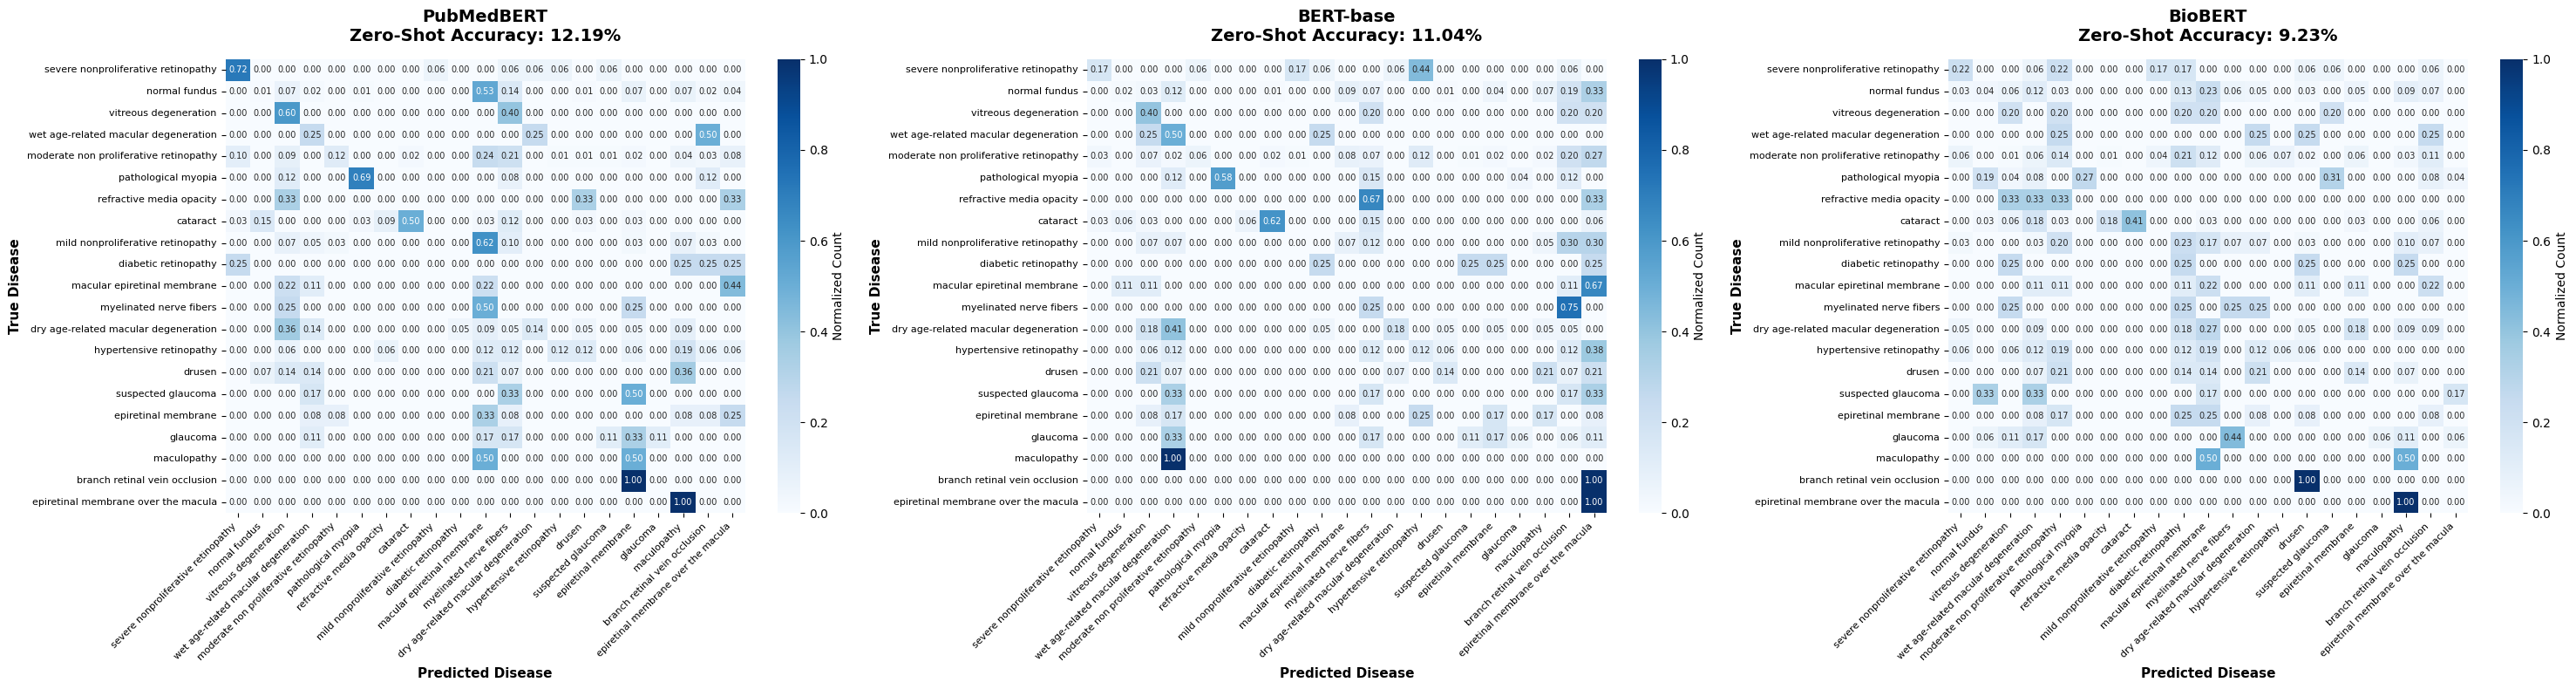


✅ Confusion matrices saved to /content/drive/MyDrive/RET-CLIP-ODIR/results/zeroshot_confusion_matrices.png


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check if we have results to visualize
if not all_results:
    print("⚠️  No results to visualize!")
else:
    # Visualize confusion matrices for all models
    num_models = len(all_results)

    if num_models == 1:
        # Single model - larger single plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        axes = [ax]
    else:
        # Multiple models - horizontal layout
        fig, axes = plt.subplots(1, num_models, figsize=(10 * num_models, 8))

    for idx, (encoder_name, results) in enumerate(all_results.items()):
        cm = confusion_matrix(results['true_labels'], results['predictions'])

        # Normalize confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plot with smaller annotations and adjusted styling
        sns.heatmap(
            cm_norm,
            annot=True,
            fmt='.2f',
            cmap='Blues',
            xticklabels=disease_classes,
            yticklabels=disease_classes,
            ax=axes[idx],
            cbar_kws={'label': 'Normalized Count'},
            annot_kws={'fontsize': 7},  # Smaller annotation font
            vmin=0,
            vmax=1
        )

        # Title
        axes[idx].set_title(
            f'{encoder_name}\nZero-Shot Accuracy: {results["accuracy"]*100:.2f}%',
            fontsize=14,
            fontweight='bold',
            pad=15
        )

        # Axis labels
        axes[idx].set_xlabel('Predicted Disease', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('True Disease', fontsize=11, fontweight='bold')

        # Tick labels - rotate and adjust size
        axes[idx].set_xticklabels(
            axes[idx].get_xticklabels(),
            rotation=45,
            ha='right',
            fontsize=8
        )
        axes[idx].set_yticklabels(
            axes[idx].get_yticklabels(),
            rotation=0,
            fontsize=8
        )

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save with high DPI for better quality
    plt.savefig(
        f'{DRIVE_RESULTS}/zeroshot_confusion_matrices.png',
        dpi=200,
        bbox_inches='tight',
        facecolor='white'
    )
    plt.show()

    print(f"\n✅ Confusion matrices saved to {DRIVE_RESULTS}/zeroshot_confusion_matrices.png")

# SECTION 8: Linear Probing Evaluation

Test the quality of learned visual representations by training a simple linear classifier (logistic regression) on frozen features.

Linear probing freezes the model weights and only trains a classifier on top, measuring how linearly separable the learned features are.

## Cell 8.1: Extract Features from Train and Test Sets

Extract frozen image features from all trained models to use for linear classifier training.

In [ ]:
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Helper function to extract features from a dataset
def extract_features(model, dataframe, desc="Extracting features"):
    """Extract image features from a dataframe of patients."""
    features = []
    labels = []

    with torch.no_grad():
        for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc=desc):
            patient_id = row['patient_id']

            # Load images
            left_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_left.jpg"
            right_img_path = f"{ODIR_IMAGES_DIR}/{patient_id}_right.jpg"

            if not os.path.exists(left_img_path) or not os.path.exists(right_img_path):
                continue

            left_img = Image.open(left_img_path).convert('RGB')
            right_img = Image.open(right_img_path).convert('RGB')

            left_tensor = preprocess(left_img).unsqueeze(0).cuda()
            right_tensor = preprocess(right_img).unsqueeze(0).cuda()

            # Encode binocular pair (RET-CLIP binocular architecture expects both images)
            img_output = model.encode_image(left_tensor, right_tensor)

            # Handle tuple return (some models return tuple of features)
            if isinstance(img_output, tuple):
                img_feat = img_output[0]
            else:
                img_feat = img_output

            # Normalize features
            img_feat = F.normalize(img_feat, dim=-1)

            features.append(img_feat.cpu())

            # Get true label (use primary keyword)
            left_kw = get_primary_disease(row['left_keywords'])
            right_kw = get_primary_disease(row['right_keywords'])
            primary_keyword = left_kw if left_kw else right_kw

            if primary_keyword in disease_classes:
                labels.append(disease_classes.index(primary_keyword))
            else:
                labels.append(0)

    features = torch.cat(features, dim=0).numpy()
    labels = np.array(labels)

    return features, labels

# Store features for all models
all_linear_probe_data = {}

# Determine which models to evaluate
if RUN_TEXT_ENCODER_COMPARISON:
    models_to_evaluate = TEXT_ENCODERS
else:
    models_to_evaluate = [{
        "name": "PubMedBERT",
        "model_id": TEXT_MODEL,
        "description": "Default text encoder"
    }]

for encoder_config in models_to_evaluate:
    encoder_name = encoder_config["name"]
    encoder_model_id = encoder_config["model_id"]
    encoder_short_name = encoder_name.lower().replace('-', '').replace(' ', '')
    model_name = f"retclip_odir_{encoder_short_name}"

    print("\n" + "="*80)
    print(f"Extracting features for: {encoder_name}")
    print("="*80)

    # Load model
    from RET_CLIP.clip.model import CLIP

    vision_config_path = f"/content/retclip/RET_CLIP/clip/model_configs/{VISION_MODEL}.json"
    text_config_path = f"/content/retclip/RET_CLIP/clip/model_configs/{encoder_model_id}.json"

    with open(vision_config_path, 'r') as fv, open(text_config_path, 'r') as ft:
        model_cfg = json.load(fv)
        for k, v in json.load(ft).items():
            model_cfg[k] = v

    model = CLIP(**model_cfg)

    checkpoint_path = f"{DRIVE_CHECKPOINTS}/{model_name}/checkpoints/epoch_latest.pt"
    print(f"  Loading: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    # Handle DDP state dict
    state_dict = checkpoint['state_dict']
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k.replace('module.', '')
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    model = model.cuda()
    model.eval()

    print("  ✅ Model loaded")

    # Extract train features
    print(f"\n  Extracting train features from {len(train_df)} patients...")
    train_features, train_labels = extract_features(model, train_df, desc=f"  Train")
    print(f"  ✅ Train features: {train_features.shape}")

    # Extract test features
    print(f"\n  Extracting test features from {len(test_df)} patients...")
    test_features, test_labels = extract_features(model, test_df, desc=f"  Test")
    print(f"  ✅ Test features: {test_features.shape}")

    # Store data
    all_linear_probe_data[encoder_name] = {
        "train_features": train_features,
        "train_labels": train_labels,
        "test_features": test_features,
        "test_labels": test_labels,
        "model_name": model_name
    }

    # Clean up GPU memory
    del model
    torch.cuda.empty_cache()

print("\n" + "="*80)
print("✅ Feature extraction complete for all models")
print("="*80)


Extracting features for: PubMedBERT
transformer int finished
vit int finished
  Loading: /content/drive/MyDrive/RET-CLIP-ODIR/checkpoints/retclip_odir_pubmedbert/checkpoints/epoch_latest.pt
  ✅ Model loaded

  Extracting train features from 2427 patients...


  Train:   0%|          | 0/2427 [00:00<?, ?it/s]

  ✅ Train features: (2427, 512)

  Extracting test features from 607 patients...


  Test:   0%|          | 0/607 [00:00<?, ?it/s]

  ✅ Test features: (607, 512)

Extracting features for: BERT-base
transformer int finished
vit int finished
  Loading: /content/drive/MyDrive/RET-CLIP-ODIR/checkpoints/retclip_odir_bertbase/checkpoints/epoch_latest.pt
  ✅ Model loaded

  Extracting train features from 2427 patients...


  Train:   0%|          | 0/2427 [00:00<?, ?it/s]

  ✅ Train features: (2427, 512)

  Extracting test features from 607 patients...


  Test:   0%|          | 0/607 [00:00<?, ?it/s]

  ✅ Test features: (607, 512)

Extracting features for: BioBERT
transformer int finished
vit int finished
  Loading: /content/drive/MyDrive/RET-CLIP-ODIR/checkpoints/retclip_odir_biobert/checkpoints/epoch_latest.pt
  ✅ Model loaded

  Extracting train features from 2427 patients...


  Train:   0%|          | 0/2427 [00:00<?, ?it/s]

  ✅ Train features: (2427, 512)

  Extracting test features from 607 patients...


  Test:   0%|          | 0/607 [00:00<?, ?it/s]

  ✅ Test features: (607, 512)

✅ Feature extraction complete for all models


## Cell 8.2: Train Logistic Regression Classifiers

Train a linear classifier on frozen features for each model and evaluate performance.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import json

# Store linear probe results
all_linear_probe_results = {}

for encoder_name, data in all_linear_probe_data.items():
    encoder_short_name = encoder_name.lower().replace('-', '').replace(' ', '')

    print("\n" + "="*80)
    print(f"Training linear classifier for: {encoder_name}")
    print("="*80)

    # Train logistic regression
    print("  Training logistic regression...")
    clf = LogisticRegression(
        max_iter=1000,
        random_state=42,
        multi_class='multinomial',
        solver='lbfgs',
        n_jobs=-1
    )

    clf.fit(data['train_features'], data['train_labels'])
    print("  ✅ Training complete")

    # Predict on test set
    print("  Evaluating on test set...")
    test_predictions = clf.predict(data['test_features'])

    # Compute metrics
    accuracy = accuracy_score(data['test_labels'], test_predictions)
    f1_macro = f1_score(data['test_labels'], test_predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(data['test_labels'], test_predictions, average='weighted', zero_division=0)

    print(f"\n  📊 Linear Probe Results for {encoder_name}:")
    print(f"     Accuracy: {accuracy * 100:.2f}%")
    print(f"     F1 (Macro): {f1_macro * 100:.2f}%")
    print(f"     F1 (Weighted): {f1_weighted * 100:.2f}%")

    # Store results
    all_linear_probe_results[encoder_name] = {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "predictions": test_predictions,
        "true_labels": data['test_labels'],
        "classifier": clf
    }

    # Save metrics
    metrics_path = f"{DRIVE_RESULTS}/linear_probe_metrics_{encoder_short_name}.json"
    with open(metrics_path, 'w') as f:
        json.dump({
            "encoder_name": encoder_name,
            "accuracy": float(accuracy),
            "f1_macro": float(f1_macro),
            "f1_weighted": float(f1_weighted),
            "num_train_samples": len(data['train_labels']),
            "num_test_samples": len(data['test_labels']),
            "num_classes": len(disease_classes)
        }, f, indent=2)

    print(f"  ✅ Metrics saved to: {metrics_path}")

print("\n" + "="*80)
print("🎉 LINEAR PROBING COMPLETE!")
print("="*80)
if RUN_TEXT_ENCODER_COMPARISON:
    print(f"\nResults Summary:")
    for encoder_name, results in all_linear_probe_results.items():
        print(f"\n  {encoder_name}:")
        print(f"    Accuracy: {results['accuracy'] * 100:.2f}%")
        print(f"    F1 (Macro): {results['f1_macro'] * 100:.2f}%")
        print(f"    F1 (Weighted): {results['f1_weighted'] * 100:.2f}%")


Training linear classifier for: PubMedBERT
  Training logistic regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  ✅ Training complete
  Evaluating on test set...

  📊 Linear Probe Results for PubMedBERT:
     Accuracy: 58.81%
     F1 (Macro): 20.47%
     F1 (Weighted): 52.68%
  ✅ Metrics saved to: /content/drive/MyDrive/RET-CLIP-ODIR/results/linear_probe_metrics_pubmedbert.json

Training linear classifier for: BERT-base
  Training logistic regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  ✅ Training complete
  Evaluating on test set...

  📊 Linear Probe Results for BERT-base:
     Accuracy: 57.17%
     F1 (Macro): 20.47%
     F1 (Weighted): 52.09%
  ✅ Metrics saved to: /content/drive/MyDrive/RET-CLIP-ODIR/results/linear_probe_metrics_bertbase.json

Training linear classifier for: BioBERT
  Training logistic regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  ✅ Training complete
  Evaluating on test set...

  📊 Linear Probe Results for BioBERT:
     Accuracy: 49.26%
     F1 (Macro): 12.72%
     F1 (Weighted): 43.20%
  ✅ Metrics saved to: /content/drive/MyDrive/RET-CLIP-ODIR/results/linear_probe_metrics_biobert.json

🎉 LINEAR PROBING COMPLETE!

Results Summary:

  PubMedBERT:
    Accuracy: 58.81%
    F1 (Macro): 20.47%
    F1 (Weighted): 52.68%

  BERT-base:
    Accuracy: 57.17%
    F1 (Macro): 20.47%
    F1 (Weighted): 52.09%

  BioBERT:
    Accuracy: 49.26%
    F1 (Macro): 12.72%
    F1 (Weighted): 43.20%


## Cell 8.3: Visualize Linear Probing Confusion Matrices

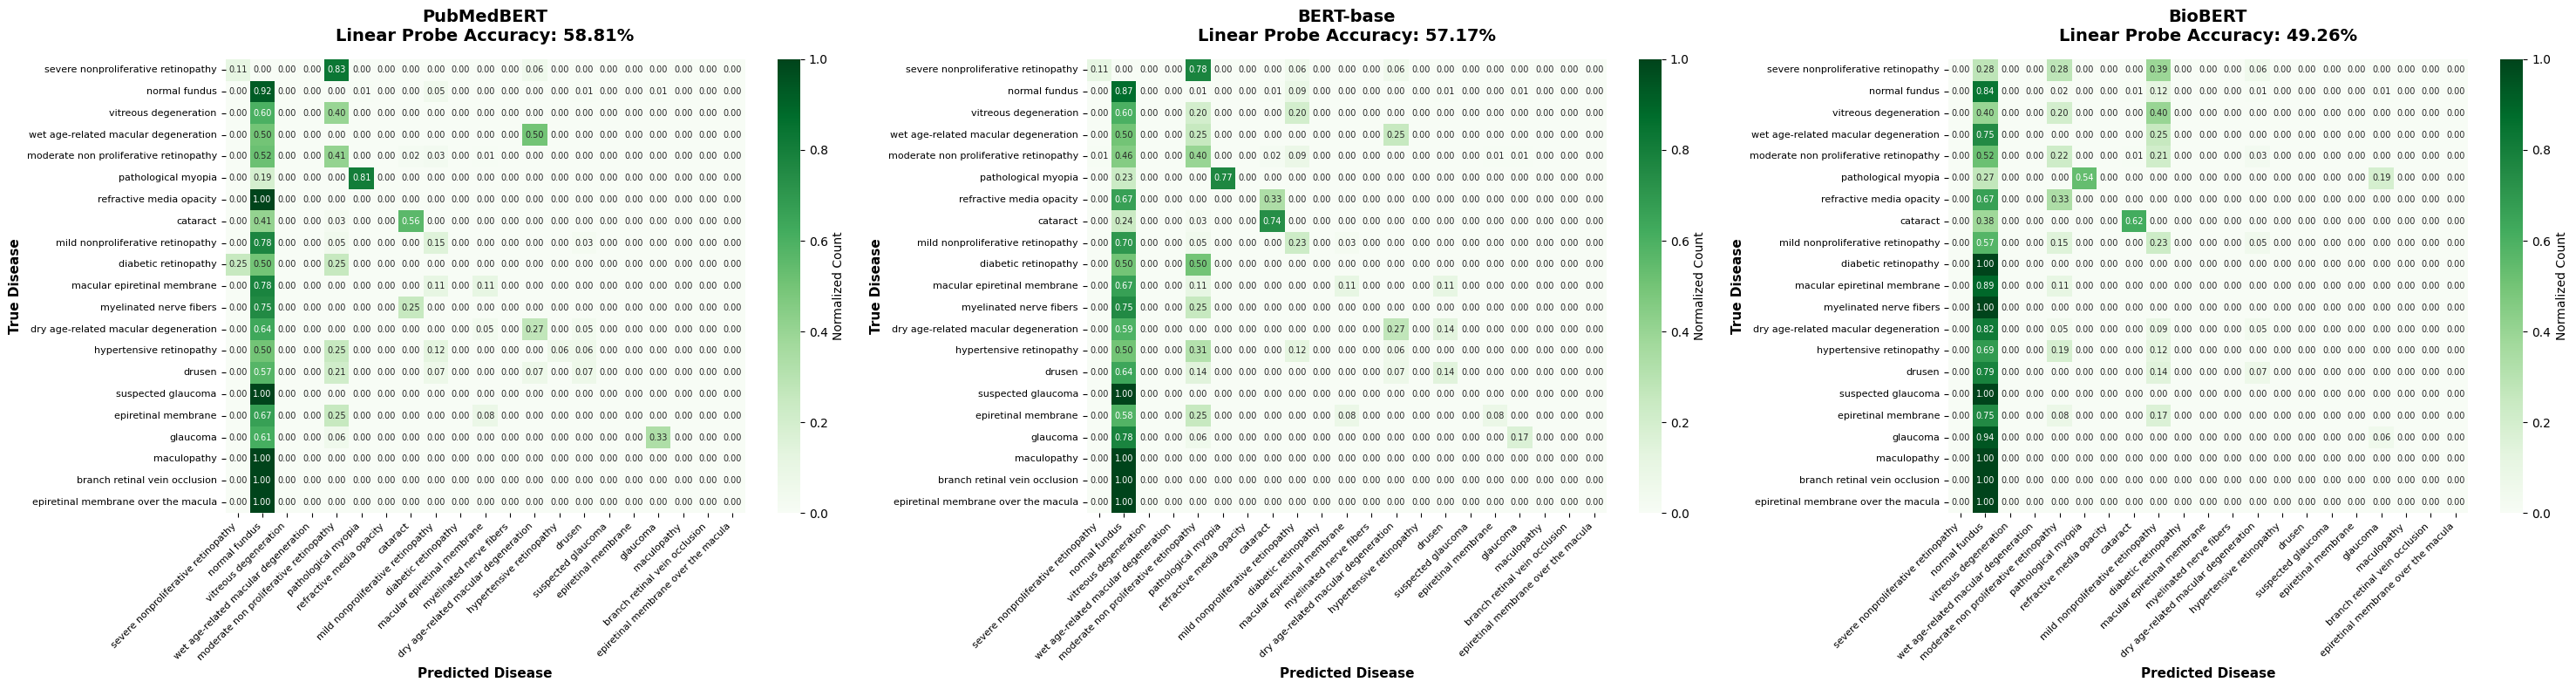


✅ Confusion matrices saved to /content/drive/MyDrive/RET-CLIP-ODIR/results/linear_probe_confusion_matrices.png
  ✅ Saved: /content/drive/MyDrive/RET-CLIP-ODIR/results/linear_probe_cm_pubmedbert.png
  ✅ Saved: /content/drive/MyDrive/RET-CLIP-ODIR/results/linear_probe_cm_bertbase.png
  ✅ Saved: /content/drive/MyDrive/RET-CLIP-ODIR/results/linear_probe_cm_biobert.png


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check if we have results to visualize
if not all_linear_probe_results:
    print("⚠️  No results to visualize!")
else:
    # Create confusion matrices for all models
    num_models = len(all_linear_probe_results)

    if num_models == 1:
        # Single model - larger single plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        axes = [ax]
    else:
        # Multiple models - horizontal layout
        fig, axes = plt.subplots(1, num_models, figsize=(10 * num_models, 8))

    for idx, (encoder_name, results) in enumerate(all_linear_probe_results.items()):
        # Compute confusion matrix
        cm = confusion_matrix(results['true_labels'], results['predictions'])

        # Normalize by row (true labels)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plot with smaller annotations and adjusted styling
        sns.heatmap(
            cm_norm,
            annot=True,
            fmt='.2f',
            cmap='Greens',
            xticklabels=disease_classes,
            yticklabels=disease_classes,
            ax=axes[idx],
            cbar_kws={'label': 'Normalized Count'},
            annot_kws={'fontsize': 7},  # Smaller annotation font
            vmin=0,
            vmax=1
        )

        # Title
        axes[idx].set_title(
            f'{encoder_name}\nLinear Probe Accuracy: {results["accuracy"]*100:.2f}%',
            fontsize=14,
            fontweight='bold',
            pad=15
        )

        # Axis labels
        axes[idx].set_xlabel('Predicted Disease', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('True Disease', fontsize=11, fontweight='bold')

        # Tick labels - rotate and adjust size
        axes[idx].set_xticklabels(
            axes[idx].get_xticklabels(),
            rotation=45,
            ha='right',
            fontsize=8
        )
        axes[idx].set_yticklabels(
            axes[idx].get_yticklabels(),
            rotation=0,
            fontsize=8
        )

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save with high DPI for better quality
    plt.savefig(
        f'{DRIVE_RESULTS}/linear_probe_confusion_matrices.png',
        dpi=200,
        bbox_inches='tight',
        facecolor='white'
    )
    plt.show()

    print(f"\n✅ Confusion matrices saved to {DRIVE_RESULTS}/linear_probe_confusion_matrices.png")

    # Also save individual confusion matrices for each model
    for encoder_name, results in all_linear_probe_results.items():
        encoder_short_name = encoder_name.lower().replace('-', '').replace(' ', '')

        # Compute confusion matrix
        cm = confusion_matrix(results['true_labels'], results['predictions'])
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Create single plot
        fig_single, ax_single = plt.subplots(figsize=(12, 10))
        sns.heatmap(
            cm_norm,
            annot=True,
            fmt='.2f',
            cmap='Greens',
            xticklabels=disease_classes,
            yticklabels=disease_classes,
            ax=ax_single,
            cbar_kws={'label': 'Normalized Count'},
            annot_kws={'fontsize': 7},
            vmin=0,
            vmax=1
        )

        ax_single.set_title(
            f'Linear Probe: {encoder_name}\nAccuracy: {results["accuracy"]*100:.2f}%',
            fontsize=14,
            fontweight='bold',
            pad=15
        )
        ax_single.set_xlabel('Predicted Disease', fontsize=11, fontweight='bold')
        ax_single.set_ylabel('True Disease', fontsize=11, fontweight='bold')

        ax_single.set_xticklabels(
            ax_single.get_xticklabels(),
            rotation=45,
            ha='right',
            fontsize=8
        )
        ax_single.set_yticklabels(
            ax_single.get_yticklabels(),
            rotation=0,
            fontsize=8
        )

        plt.tight_layout()

        cm_path = f"{DRIVE_RESULTS}/linear_probe_cm_{encoder_short_name}.png"
        fig_single.savefig(cm_path, dpi=200, bbox_inches='tight', facecolor='white')
        plt.close(fig_single)

        print(f"  ✅ Saved: {cm_path}")

# SECTION 9: Final Report

Generate a comprehensive report comparing all trained models and summarizing the entire pipeline.

## Cell 9.1: Text Encoder Comparison Table

Compare zero-shot and linear probing performance across all text encoders.

In [ ]:
import pandas as pd

# Create comparison table
comparison_data = []

for encoder_name in all_results.keys():
    zs_results = all_results[encoder_name]
    lp_results = all_linear_probe_results[encoder_name]

    comparison_data.append({
        "Text Encoder": encoder_name,
        "Zero-Shot Accuracy": f"{zs_results['accuracy'] * 100:.2f}%",
        "Zero-Shot F1 (Macro)": f"{zs_results['f1_macro'] * 100:.2f}%",
        "Zero-Shot F1 (Weighted)": f"{zs_results['f1_weighted'] * 100:.2f}%",
        "Linear Probe Accuracy": f"{lp_results['accuracy'] * 100:.2f}%",
        "Linear Probe F1 (Macro)": f"{lp_results['f1_macro'] * 100:.2f}%",
        "Linear Probe F1 (Weighted)": f"{lp_results['f1_weighted'] * 100:.2f}%"
    })

comparison_df = pd.DataFrame(comparison_data)

print("="*120)
print("TEXT ENCODER COMPARISON - ZERO-SHOT VS LINEAR PROBING")
print("="*120)
print()
display(comparison_df)
print()

# Find best performers
zs_best = max(all_results.items(), key=lambda x: x[1]['accuracy'])
lp_best = max(all_linear_probe_results.items(), key=lambda x: x[1]['accuracy'])

print(f"🏆 Best Zero-Shot Performance: {zs_best[0]} ({zs_best[1]['accuracy'] * 100:.2f}%)")
print(f"🏆 Best Linear Probe Performance: {lp_best[0]} ({lp_best[1]['accuracy'] * 100:.2f}%)")

# Save comparison table
comparison_path = f"{DRIVE_RESULTS}/text_encoder_comparison.csv"
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✅ Comparison table saved to: {comparison_path}")

TEXT ENCODER COMPARISON - ZERO-SHOT VS LINEAR PROBING



,Text Encoder,Zero-Shot Accuracy,Zero-Shot F1 (Macro),Zero-Shot F1 (Weighted),Linear Probe Accuracy,Linear Probe F1 (Macro),Linear Probe F1 (Weighted)
0,PubMedBERT,12.19%,14.65%,14.55%,58.81%,20.47%,52.68%
1,BERT-base,11.04%,14.29%,13.31%,57.17%,20.47%,52.09%
2,BioBERT,9.23%,9.00%,12.30%,49.26%,12.72%,43.20%



🏆 Best Zero-Shot Performance: PubMedBERT (12.19%)
🏆 Best Linear Probe Performance: PubMedBERT (58.81%)

✅ Comparison table saved to: /content/drive/MyDrive/RET-CLIP-ODIR/results/text_encoder_comparison.csv


## Cell 9.2: Generate Comprehensive Final Report

In [ ]:
import os
from pathlib import Path

print("="*120)
print("VERIFYING ALL ARTIFACTS")
print("="*120)

# Expected artifacts
artifacts = {
    "Prompts": [
        f"{DRIVE_PROMPTS}/odir_retclip_prompts.csv"
    ],
    "Data Splits": [
        f"{DRIVE_DATA}/train_patients.csv",
        f"{DRIVE_DATA}/test_patients.csv",
        f"{DRIVE_DATA}/train_imgs.tsv",
        f"{DRIVE_DATA}/test_imgs.tsv",
        f"{DRIVE_DATA}/train_texts.jsonl",
        f"{DRIVE_DATA}/test_texts.jsonl"
    ],
    "LMDB Databases": [
        f"{DRIVE_LMDB}/train/imgs",
        f"{DRIVE_LMDB}/test/imgs"
    ],
    "Model Checkpoints": [],
    "Results & Metrics": [
        f"{DRIVE_RESULTS}/odir_dataset_statistics.png",
        f"{DRIVE_RESULTS}/text_encoder_comparison.csv",
        f"{DRIVE_RESULTS}/final_report.txt"
    ]
}

# Add checkpoints for all trained models
for encoder_config in (TEXT_ENCODERS if RUN_TEXT_ENCODER_COMPARISON else [{"name": "PubMedBERT"}]):
    encoder_short_name = encoder_config['name'].lower().replace('-', '').replace(' ', '')
    artifacts["Model Checkpoints"].append(
        f"{DRIVE_CHECKPOINTS}/retclip_odir_{encoder_short_name}/checkpoints/epoch_latest.pt"
    )
    artifacts["Results & Metrics"].extend([
        f"{DRIVE_RESULTS}/zeroshot_metrics_{encoder_short_name}.json",
        f"{DRIVE_RESULTS}/zeroshot_confusion_matrix_{encoder_short_name}.png",
        f"{DRIVE_RESULTS}/linear_probe_metrics_{encoder_short_name}.json",
        f"{DRIVE_RESULTS}/linear_probe_confusion_matrix_{encoder_short_name}.png"
    ])

# Add comparison plots if multiple models
if RUN_TEXT_ENCODER_COMPARISON:
    artifacts["Results & Metrics"].extend([
        f"{DRIVE_RESULTS}/zeroshot_comparison_all_models.png",
        f"{DRIVE_RESULTS}/linear_probe_comparison_all_models.png"
    ])

# Check each artifact
total_artifacts = 0
found_artifacts = 0
missing_artifacts = []

for category, paths in artifacts.items():
    print(f"\n{category}:")
    for path in paths:
        total_artifacts += 1
        if os.path.exists(path):
            # Get file size
            if os.path.isfile(path):
                size_mb = os.path.getsize(path) / (1024 * 1024)
                print(f"  ✅ {os.path.basename(path)} ({size_mb:.2f} MB)")
                found_artifacts += 1
            else:
                # Directory (LMDB)
                print(f"  ✅ {os.path.basename(path)} (directory)")
                found_artifacts += 1
        else:
            print(f"  ❌ {os.path.basename(path)} - NOT FOUND")
            missing_artifacts.append(path)

print("\n" + "="*120)
print(f"ARTIFACT SUMMARY: {found_artifacts}/{total_artifacts} found")
print("="*120)

if missing_artifacts:
    print(f"\n⚠️ Missing {len(missing_artifacts)} artifact(s):")
    for path in missing_artifacts:
        print(f"  - {path}")
else:
    print("\n✅ All artifacts successfully created and saved to Google Drive!")
    print(f"\n📁 Base directory: {DRIVE_BASE}")
    print(f"\n🎉 Pipeline complete! Ready for analysis and publication.")

print("\n" + "="*120)
print("NEXT STEPS")
print("="*120)
if TEST_MODE:
    print("""
1. ✅ Review test results to ensure pipeline works correctly
2. ⚠️ Set TEST_MODE = False in Cell 1.5 for full training
3. 🚀 Run full pipeline on all 5,000 patients (~18-24 hours)
4. 📊 Analyze final results and write research paper
5. 📄 Target venues: MICCAI, IEEE TMI, or similar
""")
else:
    print("""
1. ✅ Full pipeline complete on all patients
2. 📊 Analyze results and create visualizations
3. 📝 Write research paper draft
4. 🔬 Consider additional experiments:
   - Fine-tuning on downstream tasks
   - Ablation studies
   - Cross-dataset validation
5. 📄 Submit to target venue (MICCAI, IEEE TMI, etc.)
""")

VERIFYING ALL ARTIFACTS

Prompts:
  ✅ odir_retclip_prompts.csv (1.75 MB)

Data Splits:
  ✅ train_patients.csv (1.42 MB)
  ✅ test_patients.csv (0.33 MB)
  ✅ train_imgs.tsv (85.09 MB)
  ✅ test_imgs.tsv (21.66 MB)
  ✅ train_texts.jsonl (1.76 MB)
  ✅ test_texts.jsonl (0.41 MB)

LMDB Databases:
  ✅ imgs (directory)
  ✅ imgs (directory)

Model Checkpoints:
  ✅ epoch_latest.pt (2278.80 MB)
  ✅ epoch_latest.pt (2278.80 MB)
  ✅ epoch_latest.pt (2265.38 MB)

Results & Metrics:
  ✅ odir_dataset_statistics.png (0.24 MB)
  ✅ text_encoder_comparison.csv (0.00 MB)
  ❌ final_report.txt - NOT FOUND
  ✅ zeroshot_metrics_pubmedbert.json (0.00 MB)
  ❌ zeroshot_confusion_matrix_pubmedbert.png - NOT FOUND
  ✅ linear_probe_metrics_pubmedbert.json (0.00 MB)
  ❌ linear_probe_confusion_matrix_pubmedbert.png - NOT FOUND
  ✅ zeroshot_metrics_bertbase.json (0.00 MB)
  ❌ zeroshot_confusion_matrix_bertbase.png - NOT FOUND
  ✅ linear_probe_metrics_bertbase.json (0.00 MB)
  ❌ linear_probe_confusion_matrix_bertbase.png

## Cell 9.3: List All Artifacts

Verify all output files were successfully created and saved to Google Drive.

In [ ]:
# List all expected artifacts and verify they exist
import os

print("Verifying Output Artifacts:")
print("=" * 120)

# Define expected artifacts by category
artifacts = {
    "Prompts": [
        f"{DRIVE_PROMPTS}/odir_retclip_prompts.csv"
    ],
    "Data Splits": [
        f"{DRIVE_DATA}/train_patients.csv",
        f"{DRIVE_DATA}/test_patients.csv",
        f"{DRIVE_DATA}/odir_train_imgs.tsv",
        f"{DRIVE_DATA}/odir_test_imgs.tsv",
        f"{DRIVE_DATA}/odir_train_texts.jsonl",
        f"{DRIVE_DATA}/odir_test_texts.jsonl"
    ],
    "LMDB Databases": [
        f"{DRIVE_LMDB}/train",
        f"{DRIVE_LMDB}/test"
    ],
    "Model Checkpoints": [],
    "Results & Metrics": [
        f"{DRIVE_RESULTS}/odir_dataset_statistics.png",
        f"{DRIVE_RESULTS}/zeroshot_confusion_matrices.png",
        f"{DRIVE_RESULTS}/linear_probe_confusion_matrices.png",
        f"{DRIVE_RESULTS}/final_report.txt"
    ]
}

# Add checkpoints for all trained models
if RUN_TEXT_ENCODER_COMPARISON:
    encoders_list = TEXT_ENCODERS
else:
    encoders_list = [{"name": "PubMedBERT", "model_id": TEXT_MODEL}]

for encoder_config in encoders_list:
    encoder_short_name = encoder_config['name'].lower().replace('-', '').replace(' ', '')
    model_name = f"retclip_odir_{encoder_short_name}"
    artifacts["Model Checkpoints"].append(
        f"{DRIVE_CHECKPOINTS}/{model_name}/checkpoints/epoch_latest.pt"
    )

# Verify each artifact
total_artifacts = 0
found_artifacts = 0

for category, paths in artifacts.items():
    print(f"\n{category}:")
    print("-" * 120)

    for path in paths:
        total_artifacts += 1
        exists = os.path.exists(path)
        found_artifacts += exists

        status = "✅" if exists else "❌"
        print(f"  {status} {path}")

print("\n" + "=" * 120)
print(f"Artifacts Summary: {found_artifacts}/{total_artifacts} found")

if found_artifacts == total_artifacts:
    print("✅ All artifacts successfully created!")
else:
    print(f"⚠️  {total_artifacts - found_artifacts} artifacts missing - check for errors above")

Verifying Output Artifacts:

Prompts:
------------------------------------------------------------------------------------------------------------------------
  ✅ /content/drive/MyDrive/RET-CLIP-ODIR/prompts/odir_retclip_prompts.csv

Data Splits:
------------------------------------------------------------------------------------------------------------------------
  ✅ /content/drive/MyDrive/RET-CLIP-ODIR/data/train_patients.csv
  ✅ /content/drive/MyDrive/RET-CLIP-ODIR/data/test_patients.csv
  ✅ /content/drive/MyDrive/RET-CLIP-ODIR/data/odir_train_imgs.tsv
  ❌ /content/drive/MyDrive/RET-CLIP-ODIR/data/odir_test_imgs.tsv
  ✅ /content/drive/MyDrive/RET-CLIP-ODIR/data/odir_train_texts.jsonl
  ❌ /content/drive/MyDrive/RET-CLIP-ODIR/data/odir_test_texts.jsonl

LMDB Databases:
------------------------------------------------------------------------------------------------------------------------
  ✅ /content/drive/MyDrive/RET-CLIP-ODIR/lmdb/train
  ✅ /content/drive/MyDrive/RET-CLIP-ODIR/lmdb